In [50]:
import random
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import seaborn as sns
from sklearn.model_selection import GridSearchCV,ParameterGrid,cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,learning_curve,KFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline

# 导入算法库
from sklearn.linear_model import LinearRegression,Ridge,LassoCV,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBClassifier,XGBRegressor
# import xgboost as xgb
# from xgboost import plot_importance
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from random import shuffle
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import svm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
from matplotlib.font_manager import * 
plt.style.use('ggplot')          # 配色
matplotlib.rcParams['figure.figsize'] = [20, 6] # for square canvas
# sns.set(font='SimHei')  # 解决Seaborn中文显示问题
pd.set_option('display.max_colwidth', 500)       # 设置字符串显示长度
from IPython.core.interactiveshell import InteractiveShell
from sklearn.impute import SimpleImputer
InteractiveShell.ast_node_interactivity = 'all'
#指定默认字体
myfont = FontProperties(fname='./fonts/simhei.ttf') 
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['font.family']='sans-serif'
%config IPCompleter.greedy=True

In [2]:
data=pd.read_pickle('../data/diag_all.pkl')

In [3]:
data.诊断类型.value_counts()
sum(data.病人ID.duplicated())
data.shape

阳性体征    174570
疾病诊断     27633
Name: 诊断类型, dtype: int64

157824

(202203, 19)

In [4]:
data_ino=pd.read_csv('../data/Medical_INO_details_Information.csv',encoding='gbk')

In [5]:
data.shape
data_ino.info()

(202203, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3529829 entries, 0 to 3529828
Data columns (total 14 columns):
        int64
病人ID    int64
性别      object
年龄      int64
体检总结    object
项目代码    int64
项目名称    object
检查结果    object
结果单位    object
参考范围    object
异常提示    object
正常结果    object
异常标志    float64
诊断标志    float64
dtypes: float64(2), int64(4), object(8)
memory usage: 377.0+ MB


In [6]:
# data.head()

### 在Excel（后面发现Excel未完全显示）中观察体检数据表INO，总结以下：
- 1. 诊断标志9 表示**无异常**，只有一个编号759230的体检记录中 一个男的异常提示被记录为h（其他为空白）， 但是阳性为0， 考虑为录入失误, 将'诊断标志'修正为4
  2. 诊断标志4 表示**异常**(h/阳性),除了三个：其中一个编号820410的体检记录， 一个男的异常记录为z，阳性为1， 考虑录入失误， 将'异常提示'修正为h 
  3. 诊断标志3 表示**无异常**(z/心率)   考虑转化为0
  4. 诊断标志2 表示**异常**(h)
  5. 诊断标志1 表示**异常**(l)/**心率**（无具体数值，并且阳性特征全部为0）
  6. 诊断标志0 表示**无异常**(空白)，除了一个编号759224的体检记录,异常记录为'h',阳性为0， 录入失误， 将诊断标志修正为**2**

In [7]:
data_ino.groupby('诊断标志')['异常提示'].value_counts().unstack()

异常提示,h,l,z,阳性,阴性
诊断标志,,,,,
0.0,1.0,NaN,NaN,NaN,NaN
1.0,NaN,64016.0,NaN,NaN,NaN
2.0,127360.0,NaN,NaN,NaN,NaN
3.0,NaN,NaN,75129.0,NaN,89745.0
4.0,281.0,NaN,3.0,46533.0,NaN
9.0,1.0,NaN,NaN,NaN,NaN


In [8]:
data_ino.loc[759224, '诊断标志'] = 2                 # 修正 #6

data_ino.at[(data_ino.异常提示 == 'z')&(data_ino.诊断标志 == 4), '异常提示'] = 'h' # 修正 #2

data_ino.loc[759230, '诊断标志'] = 4              # 修正 #1

data_ino['诊断标志'] = np.floor(data_ino['诊断标志'])

data_ino['诊断标志'] = data_ino.apply(lambda x: 0 if x['诊断标志'] == 3 or x['诊断标志'] > 4 else x['诊断标志'], axis=1)

In [9]:
data_ino['诊断标志'].value_counts()

0.0    341636
2.0    127361
1.0     67459
4.0     51524
Name: 诊断标志, dtype: int64

In [10]:
data_ino.groupby('异常标志')['异常提示'].value_counts().unstack()            ## 异常标志这个 0 值有点问题， 不可信
# data_ino[(data_ino.异常提示 == 'z')&(data_ino.异常标志 == 1)]

异常提示,+,-,h,l,z,阳性,阴性
异常标志,,,,,,,
0.0,4.0,415.0,2.0,1.0,1950751.0,NaN,89745.0
1.0,NaN,NaN,127646.0,64016.0,NaN,46533.0,NaN


In [11]:
temp_ino = data_ino
# 函数 填充'诊断标志'为NaN的情况 为 透视表 做准备
def fill_labels(df):
    if pd.isnull(df['诊断标志']):
        if pd.isnull(df['正常结果']):
            if df['异常提示'] == 'z':
                return 0
            elif df['异常提示'] == '+' or df['异常提示'] == 'h':
                return 2
            elif df['异常提示'] == '-' or df['异常提示'] == 'l':
                return 1
        else:
            return 0        # 正常全为0
    else:
        return df['诊断标志']
# temp_ino.at[temp_ino['诊断标志'].isnull() & -(temp_ino['正常结果'].isnull()) & (temp_ino['', '诊断标志'] = 0
temp_ino.groupby('诊断标志')['异常提示'].value_counts().unstack()                     # 处理前
temp_ino['诊断标志'] = temp_ino.apply(fill_labels, axis=1)
temp_ino.groupby('诊断标志')['异常提示'].value_counts().unstack()                      # 处理后

异常提示,h,l,z,阳性,阴性
诊断标志,,,,,
0.0,NaN,NaN,75129.0,NaN,89745.0
1.0,NaN,64016.0,NaN,NaN,NaN
2.0,127361.0,NaN,NaN,NaN,NaN
4.0,285.0,NaN,NaN,46533.0,NaN


异常提示,+,-,h,l,z,阳性,阴性
诊断标志,,,,,,,
0.0,NaN,NaN,NaN,NaN,1950751.0,NaN,89745.0
1.0,NaN,415.0,NaN,64017.0,NaN,NaN,NaN
2.0,4.0,NaN,127363.0,NaN,NaN,NaN,NaN
4.0,NaN,NaN,285.0,NaN,NaN,46533.0,NaN


但是 比如9.0 或者其他值，并且'异常提示'为NaN的 没有上榜。。。 比如'鼻','心率'

In [12]:
# data_ino.groupby(['病人ID'])
combined_ino = temp_ino.pivot_table(values='诊断标志', index='病人ID', columns='项目名称') #, aggfunc=lambda x : (label_Dict[x]))

In [13]:
for col in combined_ino.columns:
    combined_ino[col].value_counts()
# combined_ino['血压'].value_counts()

0.0    59
4.0     2
Name: *EB病毒抗体(VCA-IgA), dtype: int64

0.0    6
Name: 24小时动态血压, dtype: int64

0.0    1488
Name: ABO血型, dtype: int64

0.0    3195
Name: ABO血型鉴定(ABO), dtype: int64

0.0    16022
Name: AST/ALT, dtype: int64

0.0    32070
Name: BUN:CREA, dtype: int64

0.0    4
Name: C-肽测定, dtype: int64

0.0    236
Name: CDFI, dtype: int64

0.0    5
Name: CRP(C反应蛋白）, dtype: int64

0.0    1
Name: CRP(超敏C反应蛋白）, dtype: int64

0.0    1
Name: CT平扫所见, dtype: int64

0.0    356
2.0     20
Name: C反应蛋白(CRP), dtype: int64

0.0    236
Name: Doppler, dtype: int64

0.0    2
Name: EB IGA, dtype: int64

0.0    2
Name: EB IGM, dtype: int64

0.0    57
1.0     6
Name: FPSA/PSA比值, dtype: int64

0.0    2
Name: Fsc2, dtype: int64

0.0    2
4.0    2
Name: HLA-B27, dtype: int64

2.0    2
Name: HLA－B27/HLA－B7, dtype: int64

0.0    12
2.0     3
Name: IV型胶原IV.C, dtype: int64

0.0    1
2.0    1
Name: IgE, dtype: int64

0.0    6
2.0    4
Name: K轻链, dtype: int64

0.0    3
Name: MRI上腹部平扫+增强, dtype: int64

0.0    2
Name: NLysed-RBC#, dtype: int64

0.0    3
Name: NLysed-RBC%, dtype: int64

0.0    37434
Name: P-R间期, dtype: int64

0.0    37434
Name: P波, dtype: int64

0.0    37434
Name: Q-T间期, dtype: int64

0.0    37434
Name: QRS, dtype: int64

0.0    37434
Name: QRS时间, dtype: int64

0.0    2
Name: RBC-F1-DWSD, dtype: int64

0.0    3
Name: RBC-Fsc-DW, dtype: int64

0.0    2
Name: RBC-MF1, dtype: int64

0.0    2
Name: RBC-MFsc, dtype: int64

0.0    3
Name: RBC-P70Fsc, dtype: int64

0.0    31799
1.0     3361
2.0       17
0.5        3
Name: RBC分布宽度标准差(RDW-SD), dtype: int64

0.000000    35079
2.000000     2791
1.000000     1265
0.500000        2
0.666667        1
Name: RBC平均HGB浓度(MCHC), dtype: int64

4.0    2450
0.0      13
Name: Rh血型, dtype: int64

4.0    2240
0.0       8
Name: Rh血型(Rh), dtype: int64

0.0    37434
Name: ST段, dtype: int64

0.0    37434
Name: T波, dtype: int64

0.0    37434
Name: U波, dtype: int64

0.0    2
Name: WBC-MFsc, dtype: int64

0.0    22
2.0     1
Name: a-岩藻糖苷酶(AFU), dtype: int64

0.0    32865
2.0     2784
1.0        6
Name: γ谷氨酰胺转肽酶(GGT), dtype: int64

0.0    8
2.0    2
Name: λ轻链, dtype: int64

0.0    37434
Name: Ⅴ1Ptf, dtype: int64

0.0    12
2.0     3
Name: 三型前胶原, dtype: int64

0.0    236
Name: 三尖瓣, dtype: int64

0.0    61
1.0     8
2.0     2
Name: 三碘甲状腺原氨酸(T3), dtype: int64

0.0    8357
2.0     490
1.0       1
Name: 上皮细胞, dtype: int64

0.0    2
Name: 上皮细胞（高倍镜视野，尿红细胞形态）, dtype: int64

0.0    1
Name: 上腹部CT增强所见, dtype: int64

0.0    1
Name: 上腹部CT平扫所见, dtype: int64

0.0    1
Name: 上腹部MRI, dtype: int64

0.0    3
Name: 下腹部CT平扫所见, dtype: int64

0.0    59
Name: 下鼻甲, dtype: int64

0.0    58
Name: 不随意运动, dtype: int64

0.0    2
Name: 丙肝RNA, dtype: int64

0.0    93
Name: 丙肝抗体(ANTI_HCV), dtype: int64

0.0    19
1.0    12
Name: 中值细胞数, dtype: int64

0.0    29
2.0     2
Name: 中值细胞比率, dtype: int64

0.0    332
2.0     96
1.0     28
Name: 中性粒细胞, dtype: int64

0.0    3890
1.0     127
2.0      66
Name: 中性粒细胞数, dtype: int64

0.0    14441
1.0      888
2.0      172
0.5        1
Name: 中性粒细胞比率, dtype: int64

0.0    32871
1.0     1747
2.0      439
0.5        4
Name: 中性粒细胞百分率, dtype: int64

0.0    33308
1.0     1143
2.0      617
0.5        2
Name: 中性粒细胞绝对值, dtype: int64

0.0    2591
1.0     217
2.0      15
Name: 中性细胞百分比(%NEUT), dtype: int64

0.0    59
Name: 中道, dtype: int64

0.0    33087
2.0     1947
1.0        4
Name: 中间细胞数, dtype: int64

0.0    32849
2.0     2181
1.0        8
Name: 中间细胞百分比, dtype: int64

0.0    59
Name: 中鼻甲, dtype: int64

0.0    236
Name: 主动脉, dtype: int64

0.0    236
Name: 主动脉瓣, dtype: int64

0.0    582
4.0     74
Name: 乙型肝炎病毒前S1抗原, dtype: int64

0.0    20238
4.0     6869
Name: 乙肝e抗体(HbeAb), dtype: int64

0.0    26613
4.0      495
Name: 乙肝e抗原(HbeAg), dtype: int64

4.0    17800
0.0     9305
2.0        2
Name: 乙肝核心抗体(HbcAb), dtype: int64

4.0    17969
0.0     9138
2.0        1
Name: 乙肝表面抗体(HbsAb), dtype: int64

0.0    24822
4.0     3435
1.0      415
2.0        4
Name: 乙肝表面抗原（HBsAg）, dtype: int64

0.0    324
2.0    312
Name: 乙肝（HBV-DNA）, dtype: int64

0.0    59
Name: 乳突, dtype: int64

0.0    228
Name: 乳腺彩超, dtype: int64

0.000000    14161
2.000000      921
1.000000      100
0.666667        1
Name: 乳酸脱氢酶, dtype: int64

0.0    236
Name: 二尖瓣, dtype: int64

0.0    14291
1.0      816
2.0       71
0.5        2
Name: 二氧化碳(CO2), dtype: int64

0.0    796
2.0      3
Name: 人绒毛膜促性腺激素, dtype: int64

0.0    59
Name: 会厌, dtype: int64

1.0    7
0.0    5
2.0    5
Name: 低密度脂蛋白(LDL), dtype: int64

0.0    7497
1.0    6509
2.0    5594
0.5       2
1.5       1
Name: 低密度脂蛋白胆固醇, dtype: int64

0.0    24
Name: 促卵泡激素(FSH), dtype: int64

0.0    58
1.0    12
2.0     4
Name: 促甲状腺激素, dtype: int64

0.0    24
Name: 促黄体激素(LH), dtype: int64

0.0    2
Name: 健康状态预警检测分析, dtype: int64

0.0    7
2.0    3
Name: 免疫球蛋白IgA, dtype: int64

0.0    6
2.0    4
Name: 免疫球蛋白IgG, dtype: int64

0.0    10
Name: 免疫球蛋白IgM, dtype: int64

0.0    378
1.0     17
2.0     17
Name: 全血低切相对粘度, dtype: int64

0.0    227
2.0    185
1.0      4
Name: 全血粘度值(切变率1), dtype: int64

0.0    348
2.0     65
1.0      3
Name: 全血粘度值(切变率200), dtype: int64

0.0    328
2.0     67
1.0     21
Name: 全血粘度值(切变率30), dtype: int64

0.0    299
2.0    112
1.0      5
Name: 全血粘度值(切变率5), dtype: int64

0.0    391
1.0     15
2.0      6
Name: 全血高切相对粘度, dtype: int64

0.0    58
Name: 共济运动, dtype: int64

0.0    26495
Name: 其他, dtype: int64

0.0    3
Name: 其它, dtype: int64

0.0    3
Name: 其它数量, dtype: int64

0.0    85
2.0     3
Name: 凝血酶原时间, dtype: int64

0.0    80
2.0     8
Name: 凝血酶时间, dtype: int64

0.0    12686
Name: 前列腺, dtype: int64

0.0    786
2.0      4
4.0      1
Name: 前列腺特异性抗原, dtype: int64

0.0    221
2.0      4
Name: 前列腺特异抗原(PSA), dtype: int64

0.0    2131
Name: 前列腺（彩超）, dtype: int64

0.0    59
Name: 前后腭弓, dtype: int64

0.0    61
Name: 前房深度, dtype: int64

0.0    8
Name: 动态心电图检查, dtype: int64

0.0    66
Name: 动脉搏动, dtype: int64

0.0    45
Name: 包皮, dtype: int64

0.0    14
Name: 十二指肠球部, dtype: int64

0.0    13
Name: 十二指肠降段, dtype: int64

0.0    3836
1.0     142
2.0     106
Name: 单核细胞, dtype: int64

0.0    3999
2.0      59
1.0      26
Name: 单核细胞百分率（MO%）, dtype: int64

0.0    20
4.0     1
Name: 单纯疱疹病毒, dtype: int64

0.0    5
Name: 原特异性烯醇化酶(NSE), dtype: int64

0.0    218
Name: 双侧乳腺钼靶所见, dtype: int64

0.0    1
Name: 双侧股总动脉彩超所见, dtype: int64

0.0    53
Name: 口腔粘膜, dtype: int64

0.0    53
Name: 口腔颌面部, dtype: int64

0.0    1
Name: 右下肢血管彩超所见, dtype: int64

0.0    236
Name: 右心室, dtype: int64

0.0    236
Name: 右房, dtype: int64

0.0    1
Name: 右手指正侧位片所见, dtype: int64

0.0    2788
Name: 右眼矫正视力, dtype: int64

0.0    8661
Name: 右眼裸视力, dtype: int64

0.0    236
Name: 右肺动脉, dtype: int64

0.0    1
Name: 右腕关节正侧位片所见, dtype: int64

0.0    1
Name: 右足正侧位片, dtype: int64

0.0    1
Name: 右踝关节正侧位片, dtype: int64

0.0    1
Name: 右骶髂关节正斜位片, dtype: int64

0.0    13
2.0     4
Name: 同型半胱氨酸, dtype: int64

0.0    59
Name: 后鼻孔, dtype: int64

0.0    190
4.0      4
Name: 吗啡甲基安非他敏, dtype: int64

0.0    11843
Name: 听力, dtype: int64

0.0    42
Name: 吸烟情况, dtype: int64

0.0    66
Name: 周围血管征, dtype: int64

0.0    59
Name: 咽侧索, dtype: int64

0.0    59
Name: 咽后壁, dtype: int64

0.0    11784
Name: 喉部, dtype: int64

0.0    59
Name: 嗅沟, dtype: int64

0.0    4079
2.0       5
Name: 嗜碱性粒细胞, dtype: int64

0.0    3983
2.0     101
Name: 嗜碱粒细胞比率(BASO%), dtype: int64

0.0    3277
2.0     409
1.0     397
0.5       1
Name: 嗜酸性粒细胞, dtype: int64

0.0    3194
1.0     495
2.0     395
Name: 嗜酸粒细胞比率(EO%), dtype: int64

0.0    14941
Name: 四肢关节, dtype: int64

0.0    87
2.0     1
Name: 国际标准化比数, dtype: int64

0.0    33
Name: 在职情况, dtype: int64

0.0    59
Name: 声带, dtype: int64

0.0    59
Name: 声音, dtype: int64

0.0    58
Name: 声音嘶哑, dtype: int64

0.0    59
Name: 外耳道, dtype: int64

0.0    10099
Name: 外阴, dtype: int64

0.0    59
Name: 外鼻, dtype: int64

0.0    42
Name: 大便白细胞, dtype: int64

0.0    42
Name: 大便红细胞, dtype: int64

0.0    42
Name: 大便脂肪球, dtype: int64

0.0    35067
1.0        2
Name: 大血小板比率(P-LCR), dtype: int64

0.0    66
Name: 大血管杂音, dtype: int64

0.0    14896
Name: 头颈淋巴结, dtype: int64

0.0    29
Name: 婚姻状况, dtype: int64

0.0    12534
Name: 子宫, dtype: int64

0.0    10099
Name: 子宫体, dtype: int64

0.0    1636
Name: 子宫（彩超）, dtype: int64

0.0    23
2.0     1
Name: 孕酮(P), dtype: int64

0.0    59
Name: 室带, dtype: int64

0.0    236
Name: 室间隔, dtype: int64

0.0    10099
Name: 宫颈, dtype: int64

0.0    15
Name: 宫颈DNA所见, dtype: int64

0.0    8541
Name: 宫颈病理涂片, dtype: int64

0.0    13
Name: 家族病史, dtype: int64

0.0    28424
2.0       96
4.0       27
Name: 尿亚硝酸盐(NIT), dtype: int64

0.0    2
2.0    2
Name: 尿微量白蛋白(AlB), dtype: int64

0.0    28483
1.0       41
2.0       21
Name: 尿比重(SG), dtype: int64

0.0    3
Name: 尿沉渣上皮细胞, dtype: int64

0.0    3
Name: 尿沉渣上皮细胞（高倍视野）, dtype: int64

0.0    3
Name: 尿沉渣小圆上皮细胞, dtype: int64

0.0    3
Name: 尿沉渣病理管型, dtype: int64

0.0    3
Name: 尿沉渣白细胞, dtype: int64

0.0    3
Name: 尿沉渣白细胞(高倍视野), dtype: int64

0.0    2
2.0    1
Name: 尿沉渣管型计数, dtype: int64

0.0    3
Name: 尿沉渣管型（低倍视野）, dtype: int64

2.0    2
0.0    1
Name: 尿沉渣红细胞, dtype: int64

2.0    2
0.0    1
Name: 尿沉渣红细胞（高倍视野）, dtype: int64

0.0    3
Name: 尿沉渣细菌, dtype: int64

0.0    3
Name: 尿沉渣细菌（高倍视野）, dtype: int64

0.0    3
Name: 尿沉渣结晶数量, dtype: int64

0.0    2008
2.0      31
Name: 尿沉渣镜检白细胞, dtype: int64

0.0    2337
2.0      15
Name: 尿沉渣镜检红细胞, dtype: int64

0.0    25146
2.0     3391
1.0       10
Name: 尿白细胞(WBC), dtype: int64

0.0    3
Name: 尿离心RBC形态单一性, dtype: int64

0.0    2
2.0    1
Name: 尿离心RBC形态多形性, dtype: int64

0.0    3
Name: 尿离心后镜检RBC, dtype: int64

0.0    3
Name: 尿离心后镜检WBC, dtype: int64

0.0    28152
2.0      394
1.0        1
Name: 尿糖(GLU), dtype: int64

0.0    12
2.0     2
Name: 尿素(BUN), dtype: int64

0.0    30868
1.0     4871
2.0      539
0.5        7
Name: 尿素氮(BUN), dtype: int64

0.000000    20148
2.000000     8378
1.000000       19
0.666667        1
Name: 尿维生素C, dtype: int64

0.0    28197
2.0      349
1.0        1
Name: 尿胆原(URO), dtype: int64

0.0    28426
2.0      120
1.0        1
Name: 尿胆红素(BIL), dtype: int64

0.0    28094
2.0      452
1.0        1
Name: 尿蛋白(PRO), dtype: int64

0.0    1
Name: 尿道口（男）, dtype: int64

0.0    27129
2.0     1416
1.0        2
Name: 尿酮体(KET), dtype: int64

0.0    28917
2.0     8600
1.0       27
Name: 尿酸(UA), dtype: int64

0.0    28543
1.0        1
Name: 尿酸碱度(PH), dtype: int64

0.0    24527
2.0     4014
1.0        6
Name: 尿隐血(OLB), dtype: int64

0.0    13
2.0     2
Name: 层粘链蛋白, dtype: int64

0.0    236
Name: 左心室, dtype: int64

0.0    236
Name: 左房, dtype: int64

0.0    2766
Name: 左眼矫正视力, dtype: int64

0.0    8652
Name: 左眼裸视力, dtype: int64

0.0    1
Name: 左肩关节正位片, dtype: int64

0.0    236
Name: 左肺动脉, dtype: int64

0.0    1
Name: 左腕关节正侧位片所见, dtype: int64

0.0    1
Name: 左踝关节正侧位片, dtype: int64

0.0    21
Name: 巨细胞病毒IgG抗体, dtype: int64

0.0    61
Name: 巩膜, dtype: int64

0.0    25947
2.0    10903
1.0     2291
Name: 平均RBC血红蛋白量, dtype: int64

0.0    14896
Name: 平足, dtype: int64

0.0    13
Name: 幽门, dtype: int64

0.0    76
4.0    62
Name: 幽门螺杆菌抗体(HP), dtype: int64

0.0    21
Name: 弓形虫IgG抗体, dtype: int64

0.0    801
Name: 微生物, dtype: int64

0.0    66
Name: 心包磨擦音, dtype: int64

0.0    37435
Name: 心律, dtype: int64

0.000000    35225
0.500000     1851
1.000000     1492
0.250000        4
0.333333        3
Name: 心率, dtype: int64

0.0    37434
Name: 心电轴, dtype: int64

0.0    66
Name: 心界, dtype: int64

0.0    22299
Name: 心脏及血管, dtype: int64

0.0    753
Name: 心脏彩超, dtype: int64

0.0    66
Name: 心音, dtype: int64

0.0    86
2.0     2
Name: 总前列腺特异性抗原, dtype: int64

0.0    2
Name: 总前列腺特异性抗原(PSA)(电化学发光), dtype: int64

0.0    63
2.0     5
Name: 总前列腺特异性抗原测定(TPSA)(仪器法), dtype: int64

0.0    2
Name: 总粒子数, dtype: int64

0.0    34539
2.0     3838
1.0      259
0.5        1
Name: 总胆固醇(CHOL), dtype: int64

0.0    22
2.0     1
Name: 总胆汁酸(TBA), dtype: int64

0.0    33129
2.0     4477
1.0       41
0.5        1
Name: 总胆红素(TBIL), dtype: int64

0.0    35955
2.0     1204
1.0       53
Name: 总蛋白(TP), dtype: int64

0.0    59
Name: 悬雍垂, dtype: int64

0.0    58
Name: 情绪, dtype: int64

0.0    61
Name: 房水混浊度, dtype: int64

0.0    236
Name: 房间隔, dtype: int64

0.0    59
Name: 扁桃体, dtype: int64

0.0    3
Name: 抗-SM, dtype: int64

0.0    3
Name: 抗DSDNA抗体, dtype: int64

0.0    3
Name: 抗ENPB抗体, dtype: int64

0.0    3
Name: 抗JO-1抗体, dtype: int64

0.0    2
4.0    1
Name: 抗SS_A抗体, dtype: int64

0.0    2
4.0    1
Name: 抗SS_B抗体, dtype: int64

0.0    3
Name: 抗nRNP/sm抗体, dtype: int64

0.0    3
Name: 抗scl-70抗体, dtype: int64

0.0    1
Name: 抗子宫内膜抗体IgG, dtype: int64

0.0    1
Name: 抗子宫内膜抗体IgM, dtype: int64

0.0    3
Name: 抗核糖体P抗体, dtype: int64

4.0    1
Name: 抗环状瓜氨酸肽抗体(抗CCP), dtype: int64

0.0    3
Name: 抗组蛋白抗体定性, dtype: int64

0.0    63
Name: 抗艾滋病病毒抗体, dtype: int64

0.0    1
Name: 抗蛋白酶3(pr3), dtype: int64

0.0    373
2.0      3
Name: 抗链球菌溶血素“O”, dtype: int64

0.0    1
Name: 抗髓过氧化物酶抗体(mpo), dtype: int64

0.0    59
Name: 披裂, dtype: int64

0.0    61
Name: 指测眼压, dtype: int64

0.0    25
Name: 文化程度, dtype: int64

0.0    9
Name: 既往史, dtype: int64

0.0    61
Name: 晶体, dtype: int64

0.0    1
Name: 晶状体, dtype: int64

0.0    6
Name: 月经史, dtype: int64

0.0    5
Name: 有害物接触史, dtype: int64

0.0    801
Name: 标本质量评估, dtype: int64

0.0    80
4.0     2
Name: 梅毒密螺旋体抗体测定, dtype: int64

0.0    79
Name: 梅毒快速血浆反应素实验, dtype: int64

0.0    45
Name: 梅毒快速血浆反映素试验, dtype: int64

0.0    1
Name: 梅毒抗体实验(TPPA), dtype: int64

0.0    46
4.0     3
Name: 梅毒螺旋体粒子凝集反应, dtype: int64

0.0    59
Name: 梨状隐窝, dtype: int64

0.0    1
Name: 正常二倍体细胞, dtype: int64

0.0    1
Name: 正常增生或疑似病变细胞, dtype: int64

0.0    58
Name: 步态, dtype: int64

0.0    37
Name: 每日运动量, dtype: int64

0.0    20
2.0     5
1.0     1
Name: 泌乳素(PRL), dtype: int64

0.0    61
Name: 泪器, dtype: int64

0.0    58
Name: 浅感觉, dtype: int64

0.0    1
Name: 浅表包块, dtype: int64

0.0    45
Name: 浅表淋巴结肿大, dtype: int64

0.0    55
Name: 涂片查G双球菌, dtype: int64

0.0    53
Name: 涎腺, dtype: int64

0.0    385
2.0     36
1.0     35
Name: 淋巴细胞, dtype: int64

0.0    960
2.0    293
1.0     21
Name: 淋巴细胞比率, dtype: int64

0.0    29219
2.0     9168
1.0      744
0.5        2
Name: 淋巴细胞百分率, dtype: int64

0.0    33942
2.0     5196
1.0        3
Name: 淋巴细胞绝对值, dtype: int64

0.0    58
Name: 深感觉, dtype: int64

0.0    5536
2.0    3353
1.0       6
Name: 清洁度, dtype: int64

0.0    14
Name: 渗透压, dtype: int64

0.0    79
2.0     2
Name: 游历前列腺特异性抗原, dtype: int64

0.0    41
2.0     4
Name: 游离T3(FT3), dtype: int64

0.0    2
Name: 游离T3(发光法), dtype: int64

0.0    39
1.0     5
2.0     3
Name: 游离T4(FT4), dtype: int64

0.0    783
2.0      9
1.0      1
Name: 游离前列腺特异性抗原, dtype: int64

0.0    2252
2.0      16
Name: 游离前列腺特异抗原(FPSA), dtype: int64

0.0    2
Name: 游离前列腺特异抗原(FPSA)（电化学发光）, dtype: int64

0.0    8895
Name: 滴虫, dtype: int64

0.0    801
Name: 炎细胞量, dtype: int64

0.0    53
Name: 牙体, dtype: int64

0.0    53
Name: 牙周, dtype: int64

0.0    14
Name: 现患有疾病, dtype: int64

0.0    18
Name: 现有不适症状, dtype: int64

0.0    12
Name: 现服药情况, dtype: int64

0.0    62
Name: 玻璃体, dtype: int64

0.0    61
Name: 球结膜, dtype: int64

0.000000    34492
2.000000     2649
1.000000       70
0.333333        1
Name: 球蛋白(GLB), dtype: int64

0.000000    30215
2.000000     6357
1.000000     1742
0.500000        4
0.666667        1
Name: 甘油三酯(TG), dtype: int64

0.0    6
Name: 生育史, dtype: int64

0.0    789
2.0      2
Name: 生长激素, dtype: int64

0.0    14941
Name: 甲状腺, dtype: int64

0.0    1
Name: 甲状腺MRI所见, dtype: int64

0.0    16
Name: 甲状腺彩超, dtype: int64

0.0    19
2.0     4
Name: 甲状腺球蛋白抗体, dtype: int64

0.0    60
2.0     8
1.0     4
Name: 甲状腺素(T4), dtype: int64

0.0    20
2.0     3
Name: 甲状腺过氧化物酶抗体, dtype: int64

0.0    789
2.0      2
Name: 甲胎蛋白, dtype: int64

0.0    2
Name: 甲胎蛋白(电化学发光), dtype: int64

0.0    6243
2.0      24
Name: 甲胎蛋白定量, dtype: int64

0.0    83
2.0     5
Name: 甲胎蛋白定量(AFP), dtype: int64

0.0    18987
4.0       51
Name: 甲胎蛋白（定性）, dtype: int64

0.0    3
Name: 电导率, dtype: int64

0.0    3
Name: 疫区生活史, dtype: int64

0.0    1
Name: 病变细胞(DI>2.5), dtype: int64

0.0    58
Name: 病理反射, dtype: int64

0.0    66
Name: 病理杂音, dtype: int64

0.0    150
Name: 癌抗原(CA15-3), dtype: int64

0.0    788
2.0      4
Name: 癌抗原125, dtype: int64

0.0    145
2.0      3
Name: 癌抗原125(CA125), dtype: int64

0.0    786
2.0      5
Name: 癌抗原15-3, dtype: int64

0.0    672
2.0     14
Name: 癌肿抗原(CA-199), dtype: int64

0.0    1
Name: 癌肿抗原125(CA125), dtype: int64

0.0    27
Name: 癌胚抗原(CEA), dtype: int64

0.0    7420
2.0     100
Name: 癌胚抗原(电化学发光), dtype: int64

0.0    82
2.0     6
Name: 癌胚抗原CEA, dtype: int64

0.0    6
Name: 癌胚抗原定量, dtype: int64

0.0    786
2.0      5
Name: 癌胚抗原（CEA）, dtype: int64

0.0    17807
4.0        6
Name: 癌胚抗原（定性）, dtype: int64

0.0    7013
2.0    1810
1.0       4
Name: 白细胞, dtype: int64

0.0    418
2.0     34
1.0      4
Name: 白细胞总数, dtype: int64

0.0    37162
2.0     1071
1.0      897
0.5        3
Name: 白细胞计数(WBC), dtype: int64

0.0    37093
1.0      105
2.0       14
Name: 白蛋白(ALB), dtype: int64

0.0    36918
1.0      255
2.0       39
Name: 白蛋白/球蛋白(A/G), dtype: int64

0.0    45
Name: 皮肤, dtype: int64

0.0    14896
Name: 皮肤外表, dtype: int64

0.0    66
Name: 皮肤水肿, dtype: int64

0.0    66
Name: 皮肤皮疹, dtype: int64

0.0    66
Name: 皮肤颜色, dtype: int64

0.0    1
Name: 盆腔CT所见, dtype: int64

0.0    36519
2.0      819
1.0        1
Name: 直接胆红素, dtype: int64

0.0    6
Name: 眼压检查, dtype: int64

0.0    37
Name: 眼压计测眼压, dtype: int64

0.0    2314
Name: 眼底检查, dtype: int64

0.0    62
Name: 眼底视神经乳头, dtype: int64

0.0    62
Name: 眼底黄斑, dtype: int64

0.0    61
Name: 眼球外观, dtype: int64

0.0    61
Name: 眼球运动, dtype: int64

0.0    61
Name: 眼睑外观, dtype: int64

0.0    61
Name: 眼睑炎症及肿块, dtype: int64

0.0    61
Name: 睑结膜, dtype: int64

0.0    36
Name: 睡眠情况, dtype: int64

0.0    45
Name: 睾丸, dtype: int64

0.0    9
1.0    3
Name: 睾酮(T), dtype: int64

0.0    10
2.0     1
1.0     1
Name: 睾酮(发光法), dtype: int64

0.0    61
Name: 瞳孔, dtype: int64

0.0    42
Name: 硬度, dtype: int64

0.0    31842
1.0     3279
2.0      260
0.5        2
Name: 碱性磷酸酶(ALP), dtype: int64

0.0    791
Name: 神经原特异性稀醇化酶（NSE）, dtype: int64

0.0    47
2.0    41
Name: 神经角质烯醇化酶, dtype: int64

0.0    66
Name: 移动性浊音, dtype: int64

0.0    13
Name: 窦部, dtype: int64

0.0    58
Name: 第Ⅰ对颅神经, dtype: int64

0.0    58
Name: 第Ⅱ对颅神经, dtype: int64

0.0    58
Name: 第Ⅲ对颅神经, dtype: int64

0.0    58
Name: 第Ⅳ对颅神经, dtype: int64

0.0    58
Name: 第Ⅴ对颅神经, dtype: int64

0.0    58
Name: 第Ⅵ对颅神经, dtype: int64

0.0    58
Name: 第Ⅶ对颅神经, dtype: int64

0.0    58
Name: 第Ⅷ对颅神经, dtype: int64

0.0    58
Name: 第Ⅸ对颅神经, dtype: int64

0.0    58
Name: 第Ⅹ对颅神经, dtype: int64

0.0    58
Name: 第Ⅺ对颅神经, dtype: int64

0.0    58
Name: 第Ⅻ对颅神经, dtype: int64

0.0    3
Name: 类酵母细胞数量, dtype: int64

0.0    391
2.0     15
Name: 类风湿因子(RF), dtype: int64

0.0    107
Name: 粒细胞, dtype: int64

0.0    8
Name: 精囊, dtype: int64

0.0    2
Name: 精子数量, dtype: int64

0.0    45
Name: 精索, dtype: int64

0.0    2
Name: 精索静脉彩超所见, dtype: int64

0.0    90
2.0    81
Name: 糖化血红蛋白, dtype: int64

0.0    2
Name: 糖类抗原153, dtype: int64

0.0    87
2.0     1
Name: 糖类抗原CA153, dtype: int64

0.0    85
2.0     3
Name: 糖类抗原CA199, dtype: int64

0.0    72
2.0    16
Name: 糖类抗原CA724, dtype: int64

2.0    1
0.0    1
Name: 糖耐量试验120分钟, dtype: int64

0.0    1
Name: 糖耐量试验180分钟, dtype: int64

1.0    1
0.0    1
Name: 糖耐量试验30分钟, dtype: int64

2.0    1
Name: 糖耐量试验60分钟, dtype: int64

0.0    86
2.0     2
Name: 糖链抗原125, dtype: int64

0.0    1
Name: 糖链抗原125(E), dtype: int64

0.0    782
2.0      9
Name: 糖链抗原19-9, dtype: int64

0.0    788
2.0      3
Name: 糖链抗原242（CA242）, dtype: int64

0.0    5
2.0    1
Name: 糖链抗原724, dtype: int64

0.0    5
Name: 糖链抗原CA-199(E), dtype: int64

0.0    12401
Name: 红外线乳腺所见, dtype: int64

0.0    157
Name: 红细胞, dtype: int64

0.0    3885
2.0      95
1.0       2
Name: 红细胞分布宽度, dtype: int64

0.0    32138
2.0     3040
1.0        3
Name: 红细胞分布宽度（RDW-CV）, dtype: int64

0.000000    30180
1.000000     8855
2.000000       99
0.500000        6
0.333333        1
Name: 红细胞压积(HCT), dtype: int64

0.0    34947
1.0     2113
2.0     2081
Name: 红细胞平均体积(MCV), dtype: int64

0.0    405
2.0     51
Name: 红细胞数, dtype: int64

0.0    13
2.0     3
Name: 红细胞沉降率(ESR), dtype: int64

0.0    403
2.0      8
1.0      5
Name: 红细胞聚集指数, dtype: int64

0.0    36502
2.0     2322
1.0      308
0.5        1
Name: 红细胞计数(RBC), dtype: int64

2.0    43
Name: 纤毛菌, dtype: int64

0.0    297
1.0     28
2.0     20
Name: 纤维蛋白原, dtype: int64

0.0    1
Name: 细胞总数, dtype: int64

0.0    801
Name: 细胞成分, dtype: int64

0.0    801
Name: 细胞量, dtype: int64

0.0    66
Name: 罗音, dtype: int64

0.0    15029
2.0      115
1.0       39
Name: 羟丁酸脱氢酶, dtype: int64

0.0    11784
Name: 耳, dtype: int64

0.0    59
Name: 耳廓, dtype: int64

0.0    26
Name: 职业, dtype: int64

0.0    58
Name: 肌力, dtype: int64

0.0    58
Name: 肌张力, dtype: int64

0.0    58
Name: 肌肉萎缩, dtype: int64

0.0    25380
1.0    11880
2.0       90
0.5        6
Name: 肌酐(Cr), dtype: int64

0.0    14641
2.0      473
1.0       69
Name: 肌酸激酶, dtype: int64

0.0    47
2.0     1
Name: 肌酸激酶同工酶, dtype: int64

0.0    1
Name: 肘关节正侧位, dtype: int64

0.0    3
Name: 肛门与直肠, dtype: int64

0.0    136
Name: 肛门指诊, dtype: int64

0.0    34857
Name: 肝, dtype: int64

0.0    22365
Name: 肝脏, dtype: int64

0.0    4728
Name: 肝（彩超）, dtype: int64

0.0    2
Name: 肠镜所见, dtype: int64

0.0    66
Name: 肠鸣音, dtype: int64

0.0    5
Name: 肺CT所见, dtype: int64

0.0    2
Name: 肺功能测定, dtype: int64

0.0    236
Name: 肺动脉瓣, dtype: int64

0.0    22299
Name: 肺及呼吸道, dtype: int64

0.0    80
2.0     8
Name: 肺小细胞癌原211, dtype: int64

0.0    66
Name: 肺部呼吸音, dtype: int64

0.0    34106
Name: 肾, dtype: int64

0.0    1
Name: 肾上腺CT, dtype: int64

0.0    18
Name: 肾上腺彩超, dtype: int64

0.0    66
Name: 肾脏, dtype: int64

0.0    4733
Name: 肾（彩超）, dtype: int64

0.0    13
Name: 胃体, dtype: int64

0.0    13
Name: 胃底, dtype: int64

0.0    13
Name: 胃角, dtype: int64

0.0    34923
Name: 胆囊, dtype: int64

0.0    4728
Name: 胆囊（彩超）, dtype: int64

0.0    11784
Name: 胬肉, dtype: int64

0.0    130
2.0      8
1.0      2
Name: 胰岛素(INS), dtype: int64

4.0    1
Name: 胰岛素抗体, dtype: int64

4.0    1
Name: 胰岛素细胞抗体, dtype: int64

0.0    13129
Name: 胰腺, dtype: int64

0.0    4726
Name: 胰腺（彩超）, dtype: int64

0.0    10
2.0     2
1.0     2
Name: 胱抑素-C(CYC), dtype: int64

0.0    66
Name: 胸廓外形, dtype: int64

0.0    5
Name: 胸椎(正侧位), dtype: int64

0.0    1
Name: 胸正位+左斜位片, dtype: int64

0.0    66
Name: 胸膜磨擦音, dtype: int64

0.0    34632
Name: 胸透, dtype: int64

0.0    20
Name: 胸部CT所见, dtype: int64

0.0    134
Name: 胸部X片所见, dtype: int64

0.0    66
Name: 胸部叩诊, dtype: int64

0.0    2653
Name: 胸部正位片所见, dtype: int64

0.0    64
Name: 胸部正侧位片所见, dtype: int64

0.0    66
Name: 胸部触诊, dtype: int64

0.0    14941
Name: 脊柱, dtype: int64

0.0    19691
Name: 脾, dtype: int64

0.0    22365
Name: 脾脏, dtype: int64

0.0    4726
Name: 脾（彩超）, dtype: int64

0.0    8
Name: 腰椎CT所见, dtype: int64

0.0    1
Name: 腰椎MRI所见, dtype: int64

0.0    235
Name: 腰椎正侧位所见, dtype: int64

0.0    58
Name: 腱反射, dtype: int64

0.0    45
Name: 腹壁, dtype: int64

0.0    66
Name: 腹部包块, dtype: int64

0.0    66
Name: 腹部压痛, dtype: int64

0.0    912
Name: 膀胱, dtype: int64

0.0    1843
Name: 膀胱（彩超）, dtype: int64

0.0    1
Name: 膝关节MRI所见, dtype: int64

0.0    3
Name: 膝关节摄片, dtype: int64

0.0    9
Name: 色觉, dtype: int64

0.0    88
Name: 艾滋病抗体, dtype: int64

2.0    1
Name: 药物结晶, dtype: int64

0.0    22365
Name: 营养状况, dtype: int64

0.0    35853
2.0     2355
1.0      141
Name: 葡萄糖(GLU), dtype: int64

0.0    43
Name: 虫卵, dtype: int64

0.0    61
Name: 虹膜睫状体, dtype: int64

0.0    66
Name: 蜘蛛痣, dtype: int64

0.0    38384
1.0      496
2.0      259
Name: 血小板分布宽度(PDW), dtype: int64

0.0    4066
1.0      17
Name: 血小板压积, dtype: int64

0.0    38795
1.0      322
2.0       22
Name: 血小板平均体积(MPV), dtype: int64

0.0    383
2.0     73
Name: 血小板计数, dtype: int64

0.0    38804
2.0      225
1.0      102
Name: 血小板计数(PLT), dtype: int64

0.0    255
2.0     19
Name: 血沉, dtype: int64

0.0    330
2.0     81
1.0      5
Name: 血浆粘度值, dtype: int64

0.0    13376
1.0     1724
2.0       73
0.5        7
Name: 血清无机磷测定, dtype: int64

0.000000    14059
2.000000      824
1.000000      296
1.333333        1
Name: 血清氯(CL), dtype: int64

0.0    14943
1.0      234
2.0        3
Name: 血清钙(Ca), dtype: int64

0.0    14940
1.0      231
2.0        9
Name: 血清钠(Na), dtype: int64

0.0    14907
1.0      266
2.0        4
0.5        3
Name: 血清钾(K), dtype: int64

0.0    12
2.0     2
Name: 血清铁(Fa), dtype: int64

0.0    15051
2.0      110
1.0        5
Name: 血清镁测定, dtype: int64

0.0    61
Name: 血管, dtype: int64

0.0    1
Name: 血管MRI所见, dtype: int64

0.0    454
1.0      2
Name: 血红蛋白, dtype: int64

0.0    37859
1.0      929
2.0      345
Name: 血红蛋白(HGB), dtype: int64

0.0    9
1.0    1
Name: 补体C3含量(C3), dtype: int64

0.0    8
1.0    2
Name: 补体C4含量(C4), dtype: int64

0.0    58
Name: 表情, dtype: int64

0.0    62
Name: 视网膜, dtype: int64

0.0    9
Name: 视野, dtype: int64

0.0    61
Name: 角膜, dtype: int64

0.0    58
Name: 记忆力, dtype: int64

0.0    58
Name: 语言能力, dtype: int64

0.0    408
2.0     14
Name: 谷丙转氨酶, dtype: int64

0.0    40802
2.0     1310
1.0        1
Name: 谷丙转氨酶(ALT), dtype: int64

4.0    1
Name: 谷氨酸脱羧酶抗体, dtype: int64

0.0    20128
2.0      381
Name: 谷草转氨酶(AST), dtype: int64

0.0    13
Name: 贲门, dtype: int64

0.0    59
Name: 软腭, dtype: int64

0.0    12601
1.0     1910
2.0     1076
0.5        9
Name: 载脂蛋白A1(APOA1), dtype: int64

0.000000    12422
2.000000     1702
1.000000     1467
0.500000        3
1.333333        1
Name: 载脂蛋白B(APOB), dtype: int64

0.0    15152
Name: 载脂蛋白B:A1, dtype: int64

0.0    717
Name: 输尿管, dtype: int64

0.0    1812
Name: 输尿管（彩超）, dtype: int64

0.0    11784
Name: 辨色力, dtype: int64

0.0    7
Name: 过敏史, dtype: int64

0.0    1
Name: 透明管型（尿红细胞形态）, dtype: int64

2.0    8
0.0    7
Name: 透明质栓HA, dtype: int64

0.0    88
Name: 部分凝血活酶时间, dtype: int64

0.0    22
Name: 配偶健康状况, dtype: int64

0.0    771
2.0     20
Name: 铁蛋白, dtype: int64

0.0    14
Name: 镁, dtype: int64

0.0    30937
2.0     6394
1.0        8
Name: 间接胆红素, dtype: int64

0.0    2
Name: 阴囊、双侧睾丸、附睾彩超所见, dtype: int64

0.0    11938
2.0     3129
1.0      112
0.5        1
Name: 阴离子间隙, dtype: int64

0.0    45
Name: 阴茎龟头, dtype: int64

0.0    10099
Name: 阴道, dtype: int64

0.0    10099
Name: 阴道分泌物, dtype: int64

0.0    4
Name: 阴道彩超, dtype: int64

0.0    14530
Name: 附件, dtype: int64

0.0    1636
Name: 附件（彩超）, dtype: int64

0.0    45
Name: 附睾, dtype: int64

0.0    20
4.0     2
Name: 隐血, dtype: int64

0.0    23
2.0     1
Name: 雌二醇(E2), dtype: int64

0.0    8931
Name: 霉菌, dtype: int64

0.0    61
Name: 青光眼, dtype: int64

0.0    24
Name: 颅脑CT所见, dtype: int64

0.0    1
Name: 颈内动脉, dtype: int64

0.0    4
Name: 颈动脉, dtype: int64

0.0    1
Name: 颈椎CT平扫所见, dtype: int64

0.0    1
Name: 颈椎MRI所见, dtype: int64

0.0    1
Name: 颈椎侧位片, dtype: int64

0.0    7
Name: 颈椎正位片, dtype: int64

0.0    456
Name: 颈椎正侧位片, dtype: int64

0.0    1
Name: 颈部血管所见, dtype: int64

0.0    53
Name: 颌面部, dtype: int64

0.0    44
Name: 颜色, dtype: int64

0.0    53
Name: 颞颌关节, dtype: int64

0.0    21
Name: 风疹病毒IgG抗体, dtype: int64

0.0    13
Name: 食道, dtype: int64

0.0    42
Name: 饮酒情况, dtype: int64

0.0    23
Name: 饮食习惯, dtype: int64

0.0    36
Name: 骨密度检测, dtype: int64

0.0    16
1.0     1
Name: 高密度脂蛋白(HDL), dtype: int64

0.0    19173
1.0      291
2.0      138
0.5        1
Name: 高密度脂蛋白胆固醇, dtype: int64

0.0    59
Name: 鼓室, dtype: int64

0.0    59
Name: 鼓膜, dtype: int64

0.0    11784
Name: 鼻, dtype: int64

0.0    59
Name: 鼻中隔, dtype: int64

0.0    59
Name: 鼻前庭, dtype: int64

0.0    59
Name: 鼻咽部, dtype: int64

0.0    59
Name: 鼻底, dtype: int64

0.0    59
Name: 鼻窦压痛, dtype: int64

0.0    59
Name: 鼻腔粘膜, dtype: int64

完善血压 心率 年龄 性别

血压需要处理数值
- 高血压： 18岁成人，收缩压 >= 140 **或** 舒张压 >= 90 （单位mmHg
- 低血压： 血压低于**90/60**mmHG

In [14]:
data_press = data_ino.loc[data_ino['项目名称'] == '血压', ['病人ID', '检查结果']]
# pattern_pa
def fill_press(df):
    pattern_press = re.compile(r"(?P<收缩压>\d+)/(?P<舒张压>\d+)")
#     res = 
# data_press.apply()
pa = r"(\d+)/(\d+)"
pa_name = r"(?P<收缩压>\d+)/(?P<舒张压>\d+)"
# data_press[['收缩压', '舒张压']] = data_press.检查结果.str.extract(pa)
press_re = data_press.检查结果.str.extract(pa_name)                                   # extract() 与 extractall() 
press_res = pd.concat([data_press, press_re], axis=1).set_index('病人ID')                           # 前者找第一个匹配 后者找全部匹配（所以有match）
press_res.drop(['检查结果'], axis=1, inplace=True)
# data_press

心率的 诊断标志有问题。。。

In [15]:
# sum(res.isnull().sum())
# res == combined_ino_temp
# res.isnull()
# res.loc[res.index.isin(['3000045556']), 'ABO血型'] = 2
# res

# combined_ino_res['心率'].value_counts()#.at[:, '体检总结'] = data_report['体检总结']                #['肌酐(Cr)'] #体检总结
# sample = combined_ino_temp.sample(1) #.index.is_unique
# data_report = data_report.drop_duplicates()
# data_report.index.is_unique
# sample
def heart_beat_float(df):
#     pattern = re.compile(r"*?(\d+)*?")
#     df['检查结果'] = float(re.match(pattern, df['检查结果'].strip(' ')))
#     df['检查结果'].strip(' ')
    if type(df['检查结果']) != float:
        df['检查结果'].strip(' ')
    return df
        
# beat_pattern = re.compile(r"()")
heart_beat = data_ino.loc[data_ino['项目名称'] == '心率', ['病人ID', "检查结果"]].set_index('病人ID')
# heart_beat = heart_beat.apply(heart_beat_float, axis=0)
# heart_beat.drop(type(heart_beat['检查结果'])!=float)
# type(heart_beat['检查结果'])!=float
# heart_beat.set_index('病人ID')
#  利用掩码查看异常值 发现有奇怪文本“拒绝检查” 和 6 "61 61" "正常" 这样的异常数字
mask = heart_beat.loc[:, ['检查结果']].applymap(lambda x: isinstance(x, str) and (len(x) == 2 or len(x) == 3) and x.isdigit()).values
# mask = heart_beat.loc[:, ['检查结果']].applymap(lambda x: isinstance(x, int)).values
heart_beat.loc[:, ['检查结果']] = heart_beat.loc[:, ['检查结果']].applymap(lambda x: float(x) if isinstance(x, str) and (len(x) == 2 or len(x) == 3) and x.isdigit() else np.nan)

beat_press = pd.merge(heart_beat[mask], press_res, on='病人ID', how='left')
beat_press.rename(columns={'检查结果':"心率值"}, inplace=True)
# beat_press.drop_duplicates(inplace=True)
beat_press = beat_press[~beat_press.index.duplicated(keep='first')]            # 删去重复的病人ID（index)
sum(beat_press.index.duplicated())
beat_press.info()

0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38563 entries, 8802052942 to 9500027090
Data columns (total 3 columns):
心率值    38563 non-null float64
收缩压    22454 non-null object
舒张压    22454 non-null object
dtypes: float64(1), object(2)
memory usage: 2.4+ MB


In [16]:
# df = pd.DataFrame([[1, None], [5, 4], [4, 4]], columns=['a', 'b'])
# def apply_test(input):
#     if input.a == 1:
#         input['b'] = 3
#     return input
# def test2(input):
#     if input.isnull().sum() > 0:
#         df.drop(input)
#     return input
# sum(df.isnull().sum())
# # test_res = df.apply(test2, result_type='reduce')
# # sum(test_res.isnull().sum())
# # sum(df.isnull().sum())
# df
# test_res

# df.info()

In [17]:
data_report = data_ino[['病人ID', '年龄', '性别' ,'体检总结']].copy().set_index('病人ID')
# data_report = data_report.drop_duplicates()            ## 去重没有用？？？ 病人ID依然重复
data_report = data_report[~data_report.index.duplicated(keep='first')]

combined_ino_temp = combined_ino.copy()
combined_ino_temp = pd.merge(combined_ino_temp, data_report, on='病人ID', how='left', left_index=True, sort=False)

pattern_UP = re.compile(r' (?P<项目名称>[^↓\n]+?)：[^↓]+? ↑')     # 非贪婪匹配 ? ; 匹配1+次 + ; 匹配非符号[^]
pattern_DOWN = re.compile(r' (?P<项目名称>[^↑\n]+?)：[^↑]+? ↓')     # 非贪婪匹配 ? ; 匹配1+次 + ; 匹配非符号[^]

def fill_Combined_re(combined_ino, temp, pattern_UP=pattern_UP, pattern_DOWN=pattern_DOWN):
#     pattern_UP = r' (?P<项目名称>[^↓\n]+?)：[^↓]+? ↑'
#     item_UP = combined_ino.体检总结.str.extractall(pattern_UP)
#     list_UP = list(item_UP.项目名称.map(lambda x: x.strip()))
    combined_ino
    UP = pattern_UP.findall(str(combined_ino.体检总结))
    list_UP = list(map(lambda x: x.strip(), UP))
    for item in list_UP:
        if item in temp.columns:
#             if combined_ino[item] != 2:
#                 print('病人: ', item, " 上升值 :", combined_ino[item])
#                 print(item, ':', combined_ino.item)
#             print(item)
            combined_ino[item] = 2
#             temp.loc[temp.index.isin([combined_ino.index[0]]), item] = 2
#         else:
#             print(item)
    
#     pattern_DOWN = r' (?P<项目名称>[^↑\n]+?)：[^↑]+? ↓'
#     item_DOWN = combined_ino.体检总结.str.extractall(pattern_DOWN)
#     list_DOWN = list(item_DOWN.项目名称.map(lambda x: x.strip()))
    DOWN = pattern_DOWN.findall(str(combined_ino.体检总结))
    list_DOWN = list(map(lambda x: x.strip(), DOWN))
    for item in list_DOWN:
        if item in temp.columns:
            temp_value = combined_ino[item]
            combined_ino[item] = 1
#             if temp_value != 1:
#                 print('病人: ', item, " 下降值 :", combined_ino[item])
#             temp.loc[temp.index.isin([combined_ino.index[0]]), item] = 1
#         else:
#             print(item)
    return combined_ino

# combined_ino_temp = combined_ino_temp.sample(1000)
sum(combined_ino_temp.isnull().sum())
combined_ino_res = combined_ino_temp.copy()
res = combined_ino_temp.apply(fill_Combined_re, temp=combined_ino_res, axis=1)  #  apply 到每一行
sum(combined_ino_temp.isnull().sum())
sum(combined_ino_res.isnull().sum())
sum(res.isnull().sum())

23607908

23607908

23607908

23607905

测试正则表达式的正确性（似乎会漏掉NAN的数据，因为我感觉不止三个）

In [18]:
# pattern_UP = r' (?P<项目名称>[^↓\n]+?)：[^↓]+? ↑'
# item_UP = test_src.str.extractall(pattern_UP)
# pattern_DOWN = r' (?P<项目名称>[^↑\n]+?)：[^↑]+? ↓'
# item_DOWN = test_src.str.extractall(pattern_DOWN)
# print(item_UP)
# print(item_DOWN)
# pattern = re.compile(r' [^↓\n]+?：[^↓]+? ↑')
for i in range(111110):
    test_src = res.sample(1)
    pattern = re.compile(r' (?P<项目名称>[^↓\n]+?)：[^↓]+? ↑')     # 非贪婪匹配 ? ; 匹配1+次 + ; 匹配非符号[^]
    pattern_res = pattern.findall(str(test_src.体检总结))
    # pattern_res = pattern.findall(test_src.values[0])
    for item in list(map(lambda x: x.strip(), pattern_res)):
        if item in test_src.columns:
            if test_src[item].values != 2:
                print(test_src[item])            
# type(res)

In [19]:
train_df = pd.merge(res, beat_press, on='病人ID', how='left')
# train_df

combined_res = train_df.copy()
patient_num = combined_res.shape[0]       # 样本总数
def cut(df, cutoff):
    total_row = df.shape[0]
    for col in df.columns:
        cnt = df[col].count()
        if (cnt / total_row) < cutoff:
            df.drop(col, axis=1, inplace=True) 
#         elif(cnt / total_row)
# combined_res.apply(lambda x : x.isnull().sum()).plot()
# cut(combined_res, 0.5)                   # 缺失值2/3以上就删掉
combined_res.dropna(axis=1, thresh=patient_num/3, inplace=True)

In [20]:
combined_res.shape

(45375, 102)

In [21]:
# plt.plot([-1,2,-5,3]) 
# plt.title(u'Linux公社的网址是www.linuxidc.com',fontproperties=myfont) 
# plt.show()

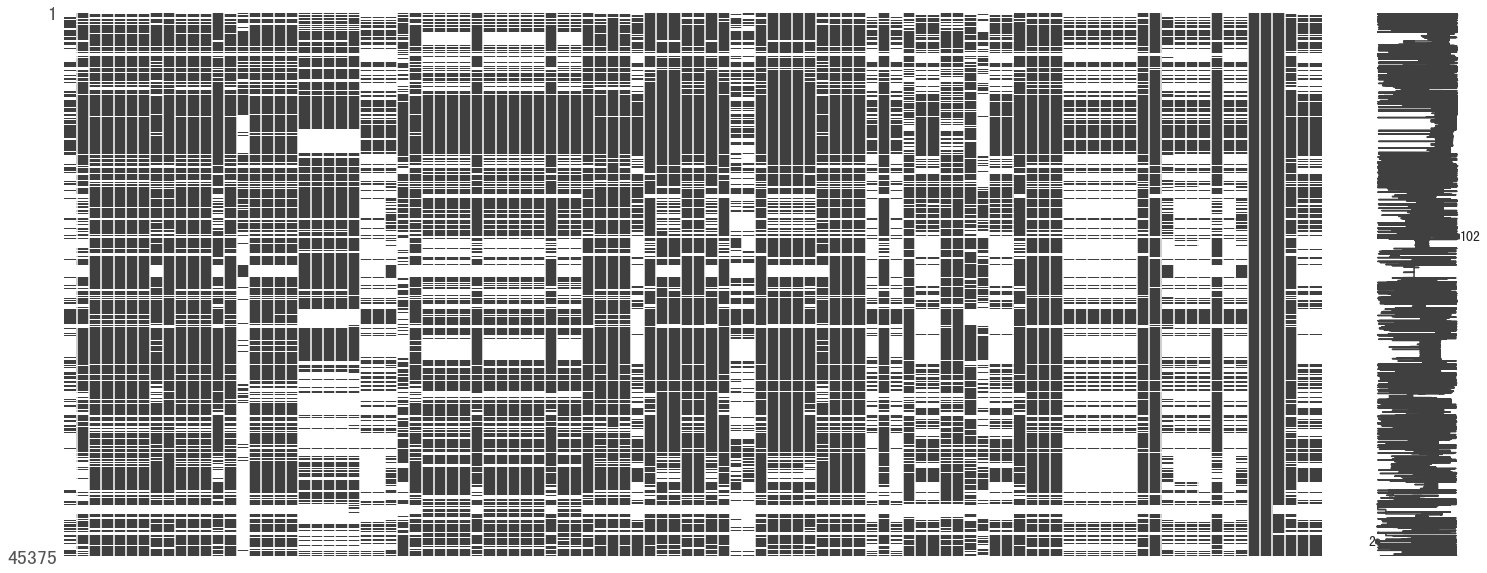

In [22]:
import missingno
missingno.matrix(combined_res)

In [23]:
gender_dict = {'男':1, '女':0}
combined_res['性别'] = combined_res['性别'].map(gender_dict)

In [44]:
combined_res.loc[:, ['心率值']].describe()              # 最小心率 最大心率惨不忍睹
combined_res.loc[:, ['心率值']].median()            # 最小心率 最大心率惨不忍睹

,心率值
count,38563.000000
mean,73.337422
std,11.646334
min,11.000000
25%,67.000000
50%,72.000000
75%,78.000000
max,801.000000


心率值    72.0
dtype: float64

查看每一个项目的 值分布

In [95]:
items = train_x.columns[:-4]
# floor_train = np.floor(train_input)
# floor_train = train_x.copy()
for item in items:
#     floor_train.loc[:, item].value_counts()
#  Series.index .values
#     floor_train.loc[:, item].value_counts()
    index = floor_train.loc[:, item].value_counts().index
    index = list(index)
    if len(index) == 0 or len(index) > 4 :
        continue
    elif index == [0, 4]:
        floor_train[:, item] = np.where(floor_train[:, item] == 4, 1, 0)
    elif index == [0, 1, 2]:
        bins = pd.get_dummies(floor_train[item])
        bins.rename(columns={0: item+'_正常', 1: item+'低', 2: item+'高'}, inplace=True)   
        floor_train = pd.concat([floor_train, bins], axis=1)

        floor_train = floor_train.drop(columns = [item])  

# gender_bin = pd.get_dummies(combined_temp['性别'])
# gender_bin.rename(columns={0:'男', 1:'女'}, inplace=True)   
# combined_temp = pd.concat([combined_temp, gender_bin], axis=1)

# combined_temp = combined_temp.drop(columns=['性别'])  

TypeError: '(slice(None, None, None), '乙肝e抗体(HbeAb)')' is an invalid key

In [85]:
array([0])

NameError: name 'array' is not defined

In [46]:
imp_median = SimpleImputer(strategy="median")                 # 使用中位数填充
combined_temp = combined_res.drop(columns=['体检总结'], axis=1)
combined_temp.loc[:, :] = imp_median.fit_transform(combined_temp)

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
# combined_temp

combined_temp.loc[:, '年龄'] = np.where(combined_temp.loc[:, '年龄']>100,  combined_temp.loc[:, '年龄'].median(), combined_temp.loc[:, '年龄'])
combined_temp.loc[:, '心率值'] = np.where(combined_temp.loc[:, '心率值']>150,  combined_temp.loc[:, '心率值'].median(), combined_temp.loc[:, '心率值'])

# 连续变量编码： 年龄：kmeans分箱， 心率： 等位分箱（数量相等）
width_est = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')          
count_est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')         
age_dummies = combined_temp.loc[:, '年龄'].values.reshape(-1, 1) 
combined_temp.loc[:, '年龄'] = width_est.fit_transform(age_dummies)
heart_dummies = combined_temp.loc[:, '心率值'].values.reshape(-1, 1)
combined_temp.loc[:, '心率值'] = count_est.fit_transform(heart_dummies)

# Onehot-encode 性别（无关离散）
# gender_enc = OneHotEncoder()
# gender_bin = combined_temp.loc[:, '性别'].values.reshape(-1, 1)
# gender_mat = gender_enc.fit_transform(gender_bin).astype(int)
# gender_mat.columns = ['男', '女']
# gender_mat
# combined_temp = pd.concat([combined_temp, gender_mat], axis=1)
# # dummies
# gender_bin = pd.get_dummies(combined_temp['性别'])
# gender_bin.rename(columns={0:'男', 1:'女'}, inplace=True)
combined_temp = pd.concat([combined_temp, gender_bin], axis=1)
combined_temp

# combined_temp = combined_temp.drop(columns=['性别'])         

,AST/ALT,BUN:CREA,P-R间期,P波,Q-T间期,QRS,QRS时间,RBC分布宽度标准差(RDW-SD),RBC平均HGB浓度(MCHC),ST段,...,间接胆红素,阴离子间隙,高密度脂蛋白胆固醇,年龄,性别,心率值,收缩压,舒张压,男,女
病人ID,,,,,,,,,,,,,,,,,,,,,
3000045556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,1.0,0.0,110.0,70.0,0,1
3000099968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,2.0,100.0,60.0,1,0
3000138629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,1.0,1.0,100.0,70.0,0,1
3000139382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,3.0,1.0,0.0,120.0,80.0,0,1
3000174746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,4.0,1.0,2.0,130.0,86.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9900451742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,1.0,0.0,100.0,70.0,0,1
9900481892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,3.0,100.0,70.0,1,0
9900485423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,130.0,80.0,0,1


## 转化为有监督回归问题
参考金融风控领域的信用分的模型$^{【1】}$:$$Score = A-B*log(odds )$$  其中 $$log(odds) = w_1X_1 + w_2X_2 + w_3X_3 +...+w_nX_n = W^{T}X+b$$
其中A为补偿，B为刻度。引入违约翻倍系数PDO：
$$Score +PDO = A-B*log(2*odds)$$
使得$log(odds)$违约比率（这里可以理解为非健康：健康比例,$odds = \frac{p}{1-p}$）翻倍时，分数为$Score+PDO$,
    解两个方程，得$$B=PDO/ln(2)$$ $$A = Score_0 + B*ln(odds_0)$$
    这里的$odds_0$为基准坏好比例，这里为$\frac{19832}{25543}=0.776416$
    $ln(odds_0) = -0.253066$ 设置基准分$Score_0$为70，$PDO=20$ 代入得
    $$B = 28.853900； A = 62.698058$$
    
引用【1】：[信用评分卡模型开发与应用](shichen.name/slide/20171115scorecard/#60)
    
    【2】：基于XGBOOST的用户信用评分建模_韩修龙

In [26]:
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA          ## PCA 无监督降维得到新的正交特征矩阵，模型可解释性 差

y_pred = KMeans(n_clusters=5).fit_predict(combined_temp)

# cluster_dict = {}
# for index, v in enumerate(y_pred):
#     cluster_dict[combined_temp.columns[index]] = v

pca = PCA(n_components=0.99)             # 不直接指定降维的维度，而指定降维后的主成分方差和 比例
train_input = combined_temp.loc[:, combined_temp.columns]   # 取 输入
pca.fit(train_input)
print(pca.explained_variance_ratio_)  # 代表降维后的各主成分的方差值。方差值越大，则说明越是重要的主成分 
print(pca.explained_variance_)        # 代表降维后的各主成分的方差值占总方差值的比例，这个比例越大，则越是重要的主成分。
print(pca.n_components_)

pca_res = pca.transform(train_input)
# pca_res.columns

# sum(combined_ino_res.isnull().sum())
# # combined_ino_res == combined_ino_temp
# combined_ino_temp.isnull().sum()

# sample.get('总胆红素(TBIL)')                   # 验证OK
# sample.get('总胆红素(TBIL)')                   # 验证OK
# sample.columns              # 验证OK
# combined_ino_temp.index.is_unique            # 病人ID重复 == 

# data_ino.info()
# data_ino[(data_ino.项目代码 == 1004)]# & (data_ino.检查结果 == '阴性')]     # 同一个项目代码对应不同的 项目名称 所以 检查结果 和 异常提示 都不一样

#data_ino[data_ino['项目名称'] == '血压']

# test_src = res.sample(1)
# # test_src.values[0]
# test_src

# # list(item_DOWN.项目名称.map(lambda x: x.strip()))
# test_src.index
# item_DOWN.index[0]

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

[7.06525539e-01 2.19798107e-01 1.25640478e-02 1.02436718e-02
 4.88605831e-03 4.09119145e-03 3.59273490e-03 3.33035621e-03
 2.75295809e-03 2.58225751e-03 2.34658557e-03 2.08289547e-03
 1.88541284e-03 1.64089675e-03 1.48201834e-03 1.35874304e-03
 1.26058595e-03 1.19881116e-03 1.04811555e-03 9.34188932e-04
 9.12259910e-04 8.39481566e-04 8.02925371e-04 7.42709707e-04
 7.30640691e-04 6.78012958e-04]
[2.00730093e+02 6.24465671e+01 3.56955601e+00 2.91031686e+00
 1.38817196e+00 1.16234332e+00 1.02072745e+00 9.46183365e-01
 7.82139503e-01 7.33641973e-01 6.66685511e-01 5.91768844e-01
 5.35662298e-01 4.66193137e-01 4.21054388e-01 3.86030795e-01
 3.58143508e-01 3.40592748e-01 2.97778808e-01 2.65411257e-01
 2.59181030e-01 2.38504064e-01 2.28118130e-01 2.11010332e-01
 2.07581419e-01 1.92629419e-01]
26


发现同样的**项目名称**居然对应不一样的**项目代码**， 同样的**项目代码** 对应两个**项目名称** ==

In [27]:
data_ino.pivot_table(index=['项目代码', '项目名称'], columns='异常提示', values='诊断标志', aggfunc=len)

异常提示                +   -     h   l       z   阳性    阴性
项目代码 项目名称                                             
1002 梅毒抗体实验(TPPA) NaN NaN   NaN NaN     1.0  NaN   NaN
1004 梅毒密螺旋体抗体测定   NaN NaN   2.0 NaN    80.0  NaN   NaN
     梅毒螺旋体粒子凝集反应  NaN NaN   1.0 NaN    21.0  2.0  25.0
1006 霉菌           NaN NaN   NaN NaN    43.0  NaN   NaN
1007 霉菌           NaN NaN   NaN NaN  8906.0  NaN   NaN
...                ..  ..   ...  ..     ...  ...   ...
3937 谷丙转氨酶        NaN NaN  14.0 NaN   408.0  NaN   NaN
3977 EB IGA       NaN NaN   NaN NaN     2.0  NaN   NaN
3978 EB IGM       NaN NaN   NaN NaN     2.0  NaN   NaN
4057 CRP(C反应蛋白）   NaN NaN   NaN NaN     5.0  NaN   NaN
     CRP(超敏C反应蛋白） NaN NaN   NaN NaN     1.0  NaN   NaN

[300 rows x 7 columns]

<Figure size 1440x504 with 0 Axes>

Text(0.5, 1.0, 'gender-age')

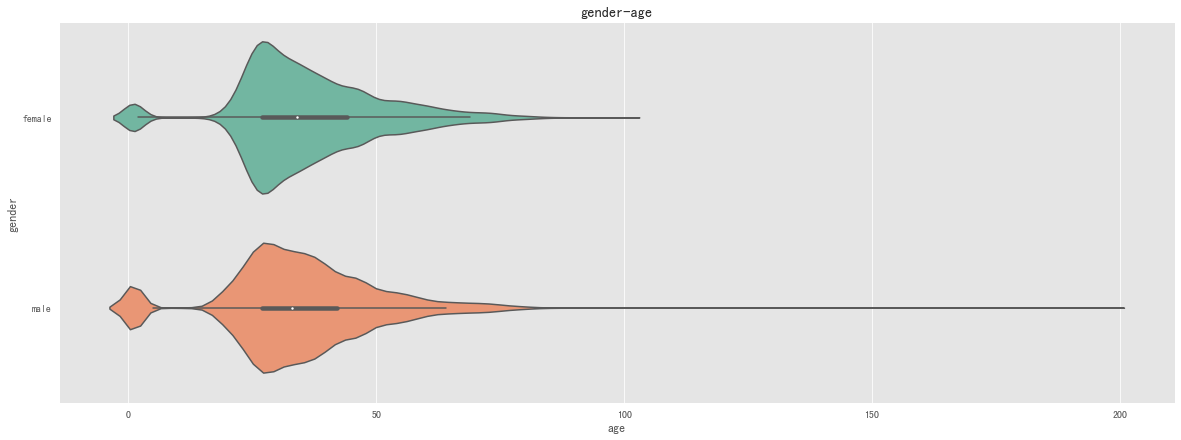

In [28]:
data_ino_age = data_ino[['年龄', '病人ID', '性别']].copy()
data_ino_age_temp = data_ino_age.rename(columns = {'年龄': 'age', '性别': 'gender'})
data_ino_age_temp.loc[data_ino_age_temp.gender == '男', ['gender']] = 'male'               # sns 不支持中文，除非加载字体
data_ino_age_temp.loc[data_ino_age_temp.gender == '女', ['gender']] = 'female'
data_ino_age_temp = data_ino_age_temp.drop_duplicates()
plt.figure(figsize=(20, 7))
sns.violinplot(x='age', data=data_ino_age_temp, orient='h', y='gender', split=True, palette='Set2', fontproperties=myfont)
plt.title('gender-age')
plt.show()

男性最大197岁应该是录入错误

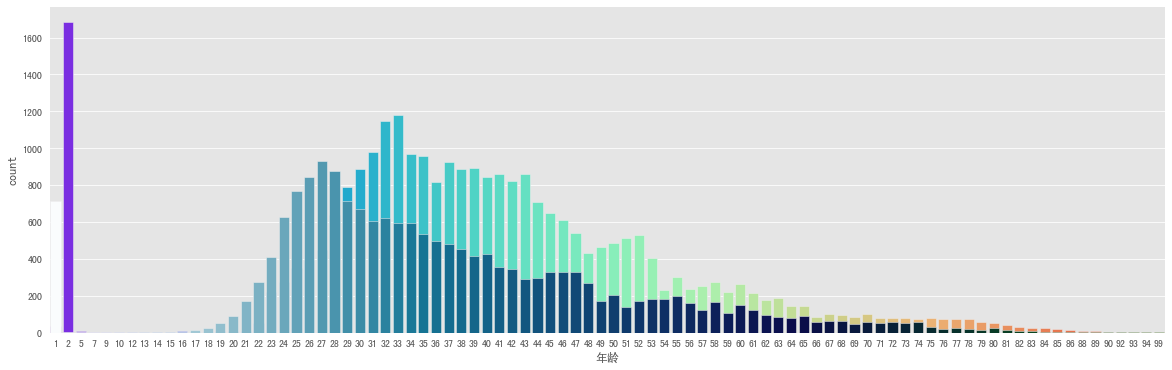

In [29]:
# age = data_ino[['病人ID', '年龄']].groupby(['病人ID'])
data_ino_female = data_ino[data_ino.性别.isin(["女", ])]
data_ino_male = data_ino[data_ino.性别.isin(["男", ])]
age_female = data_ino_female[['年龄', '病人ID']]
age_male = data_ino_male[['年龄', '病人ID']]
# age_mask = age.duplicated()
age_dup_female = age_female.drop_duplicates()
age_dup_male = age_male.drop_duplicates()
# age_dup = age_dup[['病人ID', '年龄']].value_counts()

# age_dup_female.年龄.value_counts().sort_index().plot.bar(figsize = (20, 5))
# age_dup_male_count = age_dup_male.年龄.value_counts().sort_index()
# fig, axis1 = plt.subplots(1,1,figsize=(20,5))
# age_dup_male_count['age'] = age_dup_male_count.index
# age_dup_male_count['count'] = age_dup_male_count[age_dup_male_count['age']]
# age_dup_male_count_df = age_dup_male_count.to_frame()
# age_dup_male_count_df[age] = age_dup_male_count_df.index
# sns.barplot(age_dup_male_count_df.index, age_dup_male_count_df.年龄, data = age_dup_male_count)
g = sns.countplot(x='年龄', data = age_dup_male, palette='rainbow')
# g.set_axis_labels("age", "count")
# plt.show()
g1 = sns.countplot(x='年龄', data = age_dup_female, palette='ocean_r')
# g1.set_axis_labels('age', 'count')
# age_dup.年龄.value_counts()
# age_dup_male

In [30]:
disease_rate = data.groupby('诊断名称')['诊断类型'].value_counts().unstack().fillna(0)
# 发病人数：kmeans分箱
kmeans_bins = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')    
disease_col = disease_rate.loc[:, '疾病诊断'].values.reshape(-1, 1)

disease_rate.loc[:, 'label'] = kmeans_bins.fit_transform(disease_col)
disease_rate

诊断类型,疾病诊断,阳性体征,label
诊断名称,,,
A/G增高,0.0,33.0,0.0
A型预激综合征,2.0,0.0,0.0
B超 : 胆囊息肉,1.0,0.0,0.0
B超: 肝硬化？门静脉高压？,0.0,1.0,0.0
B超子宫异常回声,9.0,0.0,0.0
...,...,...,...
鼻中隔偏曲,854.0,0.0,3.0
鼻咽炎,193.0,0.0,1.0
鼻息肉,13.0,0.0,0.0


### 在Excel（后面发现Excel未完全显示）中观察体检数据表INO，总结以下：
- 1. 诊断标志9 表示**无异常**，只有一个编号759230的体检记录中 一个男的异常提示被记录为h（其他为空白）， 但是阳性为0， 考虑为录入失误, 将'诊断标志'修正为4
  2. 诊断标志4 表示**异常**(h/阳性),除了三个：其中一个编号820410的体检记录， 一个男的异常记录为z，阳性为1， 考虑录入失误， 将'异常提示'修正为h 
  3. 诊断标志3 表示**无异常**(z/心率)   考虑转化为0
  4. 诊断标志2 表示**异常**(h)
  5. 诊断标志1 表示**异常**(l)/**心率**（无具体数值，并且阳性特征全部为0）
  6. 诊断标志0 表示**无异常**(空白)，除了一个编号759224的体检记录,异常记录为'h',阳性为0， 录入失误， 将诊断标志修正为**2**

标签：将诊断类型数为0的患者判断为健康，大于0的为非健康

In [31]:
check_temp = data.groupby('病人ID')['诊断类型'].value_counts().unstack()
check_temp.fillna(0, inplace=True)
check_temp['label'] = np.where(check_temp['疾病诊断'] == 0, 0, 1)
check_temp.drop(columns=['疾病诊断', '阳性体征'], axis=1, inplace=True)
train_x = combined_temp.copy()
train_input = pd.merge(train_x, check_temp, on='病人ID', how='left')
train_input.fillna(0, inplace=True)
train_input['label'].value_counts()
train_input

0.0    25543
1.0    19832
Name: label, dtype: int64

,AST/ALT,BUN:CREA,P-R间期,P波,Q-T间期,QRS,QRS时间,RBC分布宽度标准差(RDW-SD),RBC平均HGB浓度(MCHC),ST段,...,间接胆红素,阴离子间隙,高密度脂蛋白胆固醇,年龄,心率值,收缩压,舒张压,男,女,label
病人ID,,,,,,,,,,,,,,,,,,,,,
3000045556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,110.0,70.0,0,1,1.0
3000099968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,100.0,60.0,1,0,0.0
3000138629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,100.0,70.0,0,1,0.0
3000139382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,3.0,0.0,120.0,80.0,0,1,1.0
3000174746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,4.0,2.0,130.0,86.0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9900451742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,100.0,70.0,0,1,0.0
9900481892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,3.0,100.0,70.0,1,0,1.0
9900485423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,130.0,80.0,0,1,1.0


In [33]:
train_input['QRS'].value_counts()

0.0    45375
Name: QRS, dtype: int64

很好奇最后的结果和男女性别的关系。

结果是，男性会不健康点（可能和样本男性年龄大于女性有关）

而女性特征的被LassoLR筛选了，即认为女性和健康概率无关系

男 coef :0.004779096114211341

女 coef :-0.0

,AST/ALT,BUN:CREA,P-R间期,P波,Q-T间期,QRS,QRS时间,RBC分布宽度标准差(RDW-SD),RBC平均HGB浓度(MCHC),ST段,...,载脂蛋白B:A1,间接胆红素,阴离子间隙,高密度脂蛋白胆固醇,年龄,心率值,收缩压,舒张压,男,女
病人ID,,,,,,,,,,,,,,,,,,,,,
3000045556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.8,0.000000,0.081967,0.080402,0.0,1.0
3000099968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.4,0.666667,0.073770,0.067839,1.0,0.0
3000138629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.4,0.333333,0.073770,0.080402,0.0,1.0
3000139382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.6,0.000000,0.090164,0.092965,0.0,1.0
3000174746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.8,0.666667,0.098361,0.100503,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9900451742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.8,0.000000,0.073770,0.080402,0.0,1.0
9900481892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.4,1.000000,0.073770,0.080402,1.0,0.0
9900485423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.2,0.000000,0.098361,0.092965,0.0,1.0


Lasso picked 33 variables and eliminated the other 69 variables
AST/ALT coef :0.0
BUN:CREA coef :0.0
P-R间期 coef :0.0
P波 coef :0.0
Q-T间期 coef :0.0
QRS coef :0.0
QRS时间 coef :0.0
RBC分布宽度标准差(RDW-SD) coef :0.0
RBC平均HGB浓度(MCHC) coef :0.014692628538375737
ST段 coef :0.0
T波 coef :0.0
U波 coef :0.0
γ谷氨酰胺转肽酶(GGT) coef :0.033224624028476105
Ⅴ1Ptf coef :0.0
中性粒细胞比率 coef :-0.0
中性粒细胞百分率 coef :-0.0
中性粒细胞绝对值 coef :-0.004777941393232625
中间细胞数 coef :0.013384056333224597
中间细胞百分比 coef :0.015574948183488938
乙肝e抗体(HbeAb) coef :-0.010973838263344088
乙肝e抗原(HbeAg) coef :-0.0
乙肝核心抗体(HbcAb) coef :0.025154661879701584
乙肝表面抗体(HbsAb) coef :-0.00462447519295515
乙肝表面抗原（HBsAg） coef :-0.006046014639182027
乳酸脱氢酶 coef :0.03015479305861308
二氧化碳(CO2) coef :0.0
低密度脂蛋白胆固醇 coef :-0.025674490372670652
其他 coef :0.0
大血小板比率(P-LCR) coef :0.0
尿亚硝酸盐(NIT) coef :0.0
尿比重(SG) coef :0.0
尿白细胞(WBC) coef :0.0016779947294217007
尿糖(GLU) coef :0.0
尿素氮(BUN) coef :0.0
尿维生素C coef :0.03620919538421773
尿胆原(URO) coef :-0.0
尿胆红素(BIL) coef :-0.0
尿蛋白(PRO

<Figure size 1440x1080 with 0 Axes>

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

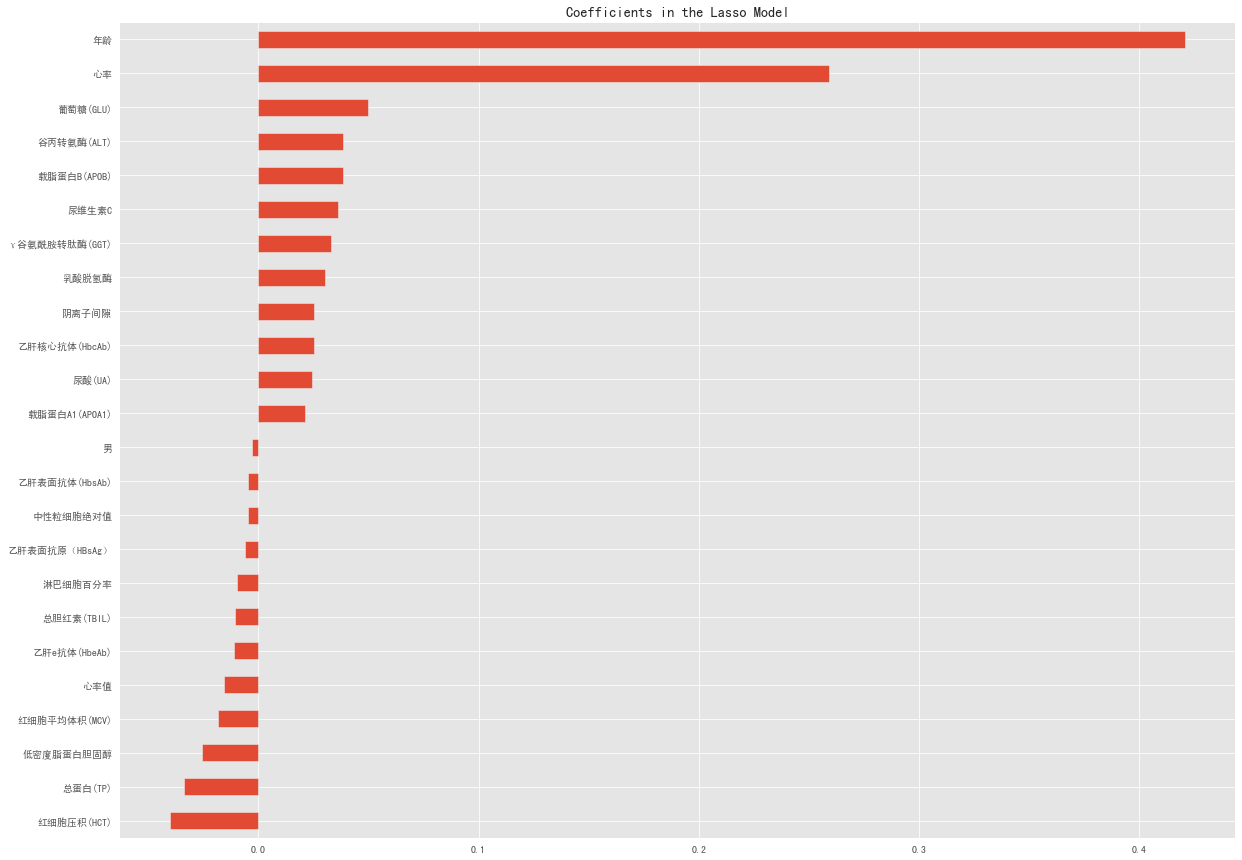

In [34]:
X_train = train_input.loc[ :, train_input.columns[:-1] ]   # 取 输入
 
# ss = StandardScaler()     # 根据方差来缩放，标准化
mm = MinMaxScaler()         #根据极大极小值，归一化
# X_train.loc[: ] = ss.fit_transform(X_train)
X_train.loc[: ] = mm.fit_transform(X_train)
X_train

y = train_input.loc[:, 'label']
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y) # 此处 alpha 为通常值 #fit 把数据套进模型里跑
coef = pd.Series(model_lasso.coef_, index = X_train.columns)             # .coef_ 可以返回经过学习后的所有 feature 的参数。
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
for c in coef.index:
    print(c + " coef :" + str(coef[c]))
imp_coef = pd.concat([coef.sort_values().head(12), 
                     coef.sort_values().tail(12)])                       #选头尾各10条，.sort_values() 可以将某一列的值进行排序。
# matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
plt.figure(figsize=(20,15))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")   

In [61]:
predict_res = model_lasso.predict(X_train)
def calculate_score(prob):
    A = 62.698058
    B = 28.853900
    return A -  B * math.log(prob / (1 - prob))
score_list = list(map(calculate_score, predict_res))

<Figure size 1440x720 with 0 Axes>

Text(0.5, 0, '分数')

Text(0, 0.5, '占比')

Text(0.5, 1.0, '分数分布')

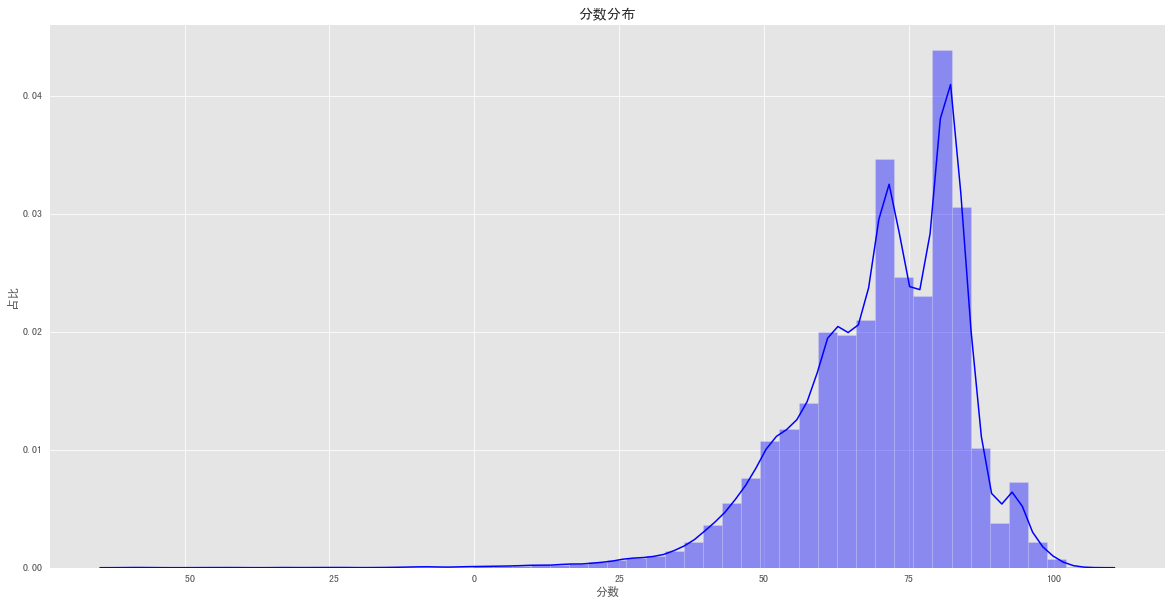

In [62]:
plt.figure(figsize=(20, 10))    # 指定画布尺寸
axis = sns.distplot(a=score_list, color='b')
axis.set_xlabel(u"分数")
axis.set_ylabel('占比')
plt.title("分数分布")
plt.show()

xgbdt的模型比线性回归表现好一点，前者分数0.182 后者0.192

In [35]:
linear_model = LinearRegression(normalize=True)
ridge_model = Ridge()
gbdt_model = GradientBoostingRegressor()
rf_model = RandomForestRegressor()
svr_model = SVR(gamma=0.01)
xgb_model = XGBRegressor()

# models = [linear_model,ridge_model,gbdt_model,rf_model,svr_model,xgb_model]
# models_names = ['linear_model','ridge_model','gbdt_model','rf_model','svr_model','xgb_model']
# models_scores_mean = []
# st_kflod = StratifiedKFold(n_splits=10,shuffle=False,random_state=0)
# for index,model in enumerate(models):
#     score = cross_val_score(estimator=model,X=X_train,y=y,scoring='neg_mean_squared_error',cv=10)
#     models_scores_mean.append(-score.mean())
#     print(f'{models_names[index]}'+'分数:' + f'{score}'+'平均分:'+f'{-score.mean()}')
#     print('-'*50)

In [36]:
data_ino.项目名称.value_counts()

心率              59885
其他              47607
谷丙转氨酶(ALT)      42165
平均RBC血红蛋白量      39188
红细胞平均体积(MCV)    39188
                ...  
右骶髂关节正斜位片           1
糖耐量试验60分钟           1
颈椎侧位片               1
右下肢血管彩超所见           1
上腹部CT增强所见           1
Name: 项目名称, Length: 615, dtype: int64

In [37]:
age = data_ino.groupby("病人ID")["年龄"].min()
# age = age.value_counts()
# age = age.unstack()
# type(age)

# data.top(5)

In [38]:
# DataFrame(data,index=[0])

# data["体检总结"]

# data.to_pickle('diag_all.pkl')
check = data.groupby("病人ID")['诊断类型'].value_counts()
# check.fillna(0)
check_res = check.unstack().fillna(0) #.describe()
# check_res.apply(lambda x: x['label'] = 0 if x['疾病诊断'] > 0 else 1)
check_res['label'] = np.where(check_res['阳性体征']==0, 0, 1)

In [39]:
check_res

诊断类型,疾病诊断,阳性体征,label
病人ID,,,
3000045556,6.0,1.0,1
3000099968,0.0,7.0,1
3000138629,0.0,2.0,1
3000139382,2.0,2.0,1
3000174746,4.0,11.0,1
...,...,...,...
9900451742,0.0,2.0,1
9900481892,1.0,7.0,1
9900485423,1.0,0.0,0


随机病人ID，检查data_ino和data，分别是检查结果和诊断结果

In [40]:
ID = tuple(data_ino.病人ID)
sample_ID = random.sample(ID, 1)
# sample = random.sample(data, 5)
sample_ID

# sample_ID
# sample_ID = list(sample_ID)
sample_diag = data[data.病人ID.isin(sample_ID)]
sample_diag
sample_ino = data_ino[data_ino.病人ID.isin(sample_ID)]

sample_ino.异常提示.value_counts()
sample_ino
sample_ino[-((sample_ino.异常提示.isnull()) & (sample_ino.阳性标志.isnull()) & (sample_ino.诊断标志.isnull()))]

[8802535815]

,Unnamed: 0,病人ID,体检号,体检流水号,性别,年龄,体检总结,体检建议,饮食建议,运动建议,诊断代码,诊断名称,诊断建议,诊断备注,诊断类型,诊断方位,诊断程度,诊断性质,诊断饮食建议
153507,153508,8802535815,49856001,80650208,女,60,◆内科普通: 血压:120/70\r\n\r\n◆外科普通: 未见异常\r\n\r\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\r\n\r\n◆妇科检查(未婚不宜）: 未见异常\r\n\r\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\r\n\r\n◆胸透: 心肺未见异常\r\n\r\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\r\n肝、胆、右肾、子宫、左附件、右附件未见异常。\r\n\r\n◆心电图: 窦性心律、正常心电图\r\n\r\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\r\n\r\n◆癌胚抗原定性: 未见异常\r\n\r\n◆甲胎蛋白定性: 未见异常\r\n\r\n◆血型: 未见异常\r\n\r\n◆尿常规: 尿隐血(OLB)：10(+) ↑\r\n\r\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\r\n\r\n◆白带常规(未婚不宜...,"【宫颈病理: 巴氏I+级】\r\n建议妇科咨询\r\n\r\n【谷草转氨酶增高】\r\n建议您肝科诊治,避免饮酒,避免刺激性食物,劳逸结合\r\n\r\n【载脂蛋白AI降低】\r\n建议您心内科诊治,多食新鲜有鳞鱼及季节性蔬菜水果,适当多运动\r\n\r\n【载脂蛋白B增高】\r\n低动物脂肪、低糖、低盐饮食，控制食量；保健内科咨询，应用降脂药物，加强体育锻炼.\r\n\r\n【左肾错构瘤】\r\n建议定期检查。",NaN,NaN,8068.0,宫颈病理: 巴氏I+级,建议妇科咨询,NaN,阳性体征,NaN,NaN,NaN,NaN
153508,153509,8802535815,49856001,80650208,女,60,◆内科普通: 血压:120/70\r\n\r\n◆外科普通: 未见异常\r\n\r\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\r\n\r\n◆妇科检查(未婚不宜）: 未见异常\r\n\r\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\r\n\r\n◆胸透: 心肺未见异常\r\n\r\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\r\n肝、胆、右肾、子宫、左附件、右附件未见异常。\r\n\r\n◆心电图: 窦性心律、正常心电图\r\n\r\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\r\n\r\n◆癌胚抗原定性: 未见异常\r\n\r\n◆甲胎蛋白定性: 未见异常\r\n\r\n◆血型: 未见异常\r\n\r\n◆尿常规: 尿隐血(OLB)：10(+) ↑\r\n\r\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\r\n\r\n◆白带常规(未婚不宜...,"【宫颈病理: 巴氏I+级】\r\n建议妇科咨询\r\n\r\n【谷草转氨酶增高】\r\n建议您肝科诊治,避免饮酒,避免刺激性食物,劳逸结合\r\n\r\n【载脂蛋白AI降低】\r\n建议您心内科诊治,多食新鲜有鳞鱼及季节性蔬菜水果,适当多运动\r\n\r\n【载脂蛋白B增高】\r\n低动物脂肪、低糖、低盐饮食，控制食量；保健内科咨询，应用降脂药物，加强体育锻炼.\r\n\r\n【左肾错构瘤】\r\n建议定期检查。",NaN,NaN,4293.0,谷草转氨酶增高,"建议您肝科诊治,避免饮酒,避免刺激性食物,劳逸结合",NaN,阳性体征,NaN,NaN,NaN,NaN
153509,153510,8802535815,49856001,80650208,女,60,◆内科普通: 血压:120/70\r\n\r\n◆外科普通: 未见异常\r\n\r\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\r\n\r\n◆妇科检查(未婚不宜）: 未见异常\r\n\r\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\r\n\r\n◆胸透: 心肺未见异常\r\n\r\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\r\n肝、胆、右肾、子宫、左附件、右附件未见异常。\r\n\r\n◆心电图: 窦性心律、正常心电图\r\n\r\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\r\n\r\n◆癌胚抗原定性: 未见异常\r\n\r\n◆甲胎蛋白定性: 未见异常\r\n\r\n◆血型: 未见异常\r\n\r\n◆尿常规: 尿隐血(OLB)：10(+) ↑\r\n\r\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\r\n\r\n◆白带常规(未婚不宜...,"【宫颈病理: 巴氏I+级】\r\n建议妇科咨询\r\n\r\n【谷草转氨酶增高】\r\n建议您肝科诊治,避免饮酒,避免刺激性食物,劳逸结合\r\n\r\n【载脂蛋白AI降低】\r\n建议您心内科诊治,多食新鲜有鳞鱼及季节性蔬菜水果,适当多运动\r\n\r\n【载脂蛋白B增高】\r\n低动物脂肪、低糖、低盐饮食，控制食量；保健内科咨询，应用降脂药物，加强体育锻炼.\r\n\r\n【左肾错构瘤】\r\n建议定期检查。",NaN,NaN,4352.0,载脂蛋白AI降低,"建议您心内科诊治,多食新鲜有鳞鱼及季节性蔬菜水果,适当多运动",NaN,阳性体征,NaN,NaN,NaN,NaN
153515,153516,8802535815,49856001,80650208,女,60,◆内科普通: 血压:120/70\r\n\r\n◆外科普通: 未见异常\r\n\r\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\r\n\r\n◆妇科检查(未婚不宜）: 未见异常\r\n\r\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\r\n\r\n◆胸透: 心肺未见异常\r\n\r\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\r\n肝、胆、右肾、子宫、左附件、右附件未见异常。\r\n\r\n◆心电图: 窦性心律、正常心电图\r\n\r\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\r\n\r\n◆癌胚抗原定性: 未见异常\r\n\r\n◆甲胎蛋白定性: 未见异常\r\n\r\n◆血型: 未见异常\r\n\r\n◆尿常规: 尿隐血(OLB)：10(+) ↑\r\n\r\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\r\n\r\n◆白带常规(未婚不宜...,"【宫颈病理: 巴氏I+级】\r\n建议妇科咨询\r\n\r\n【谷草转氨酶增高】\r\n建议您肝科诊治,避免饮酒,避免刺激性食物,劳逸结合\r\n\r\n【载脂蛋白AI降低】\r\n建议您心内科诊治,多食新鲜有鳞鱼及季节性蔬菜水果,适当多运动\r\n\r\n【载脂蛋白B增高】\r\n低动物脂肪、低糖、低盐饮食，控制食量；保健内科咨询，应用降脂药物，加强体育锻炼.\r\n\r\n【左肾错构瘤】\r\n建议定期检查。",NaN,NaN,4356.0,载脂蛋白B增高,低动物脂肪、低糖、低盐饮食，控制食量；保健内科咨询，应用降脂药物，加强体育锻炼.,NaN,阳性体征,NaN,NaN,NaN,NaN
153521,153522,8802535815,49856001,80650208,女,60,◆内科普通: 血压:120/70\r\n\r\n◆外科普通: 未见异常\r\n\r\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\r\n\r\n◆妇科检查(未婚不宜）: 未见异常\r\n\r\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\r\n\r\n◆胸透: 心肺未见异常\r\n\r\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\r\n肝、胆、右肾、子宫、左附件、右附件未见异常。\r\n\r\n◆心电图: 窦性心律、正常心电图\r\n\r\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\r\n\r\n◆癌胚抗原定性: 未见异常\r\n\r\n◆甲胎蛋白定性: 未见异常\r\n\r\n◆血型: 未见异常\r\n\r\n◆尿常规: 尿隐血(OLB)：10(+) ↑\r\n\r\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\r\n\r\n◆白带常规(未婚不宜...,"【宫颈病理: 巴氏I+级】\r\n建议妇科咨询\r\n\r\n【谷草转氨酶增高】\r\n建议您肝科诊治,避免饮酒,避免刺激性食物,劳逸结合\r\n\r\n【载脂蛋白AI降低】\r\n建议您心内科诊治,多食新鲜

z    67
h     4
l     3
Name: 异常提示, dtype: int64

,,病人ID,性别,年龄,体检总结,项目代码,项目名称,检查结果,结果单位,参考范围,异常提示,正常结果,异常标志,诊断标志
2601734,2601735,8802535815,女,60,◆内科普通: 血压:120/70\n\n◆外科普通: 未见异常\n\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\n\n◆妇科检查(未婚不宜）: 未见异常\n\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\n\n◆胸透: 心肺未见异常\n\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\n肝、胆、右肾、子宫、左附件、右附件未见异常。\n\n◆心电图: 窦性心律、正常心电图\n\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\n\n◆癌胚抗原定性: 未见异常\n\n◆甲胎蛋白定性: 未见异常\n\n◆血型: 未见异常\n\n◆尿常规: 尿隐血(OLB)：10(+) ↑\n\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\n\n◆白带常规(未婚不宜）: 未见异常,1705,血压,120/70,mmHg,NaN,NaN,NaN,NaN,NaN
2601735,2601736,8802535815,女,60,◆内科普通: 血压:120/70\n\n◆外科普通: 未见异常\n\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\n\n◆妇科检查(未婚不宜）: 未见异常\n\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\n\n◆胸透: 心肺未见异常\n\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\n肝、胆、右肾、子宫、左附件、右附件未见异常。\n\n◆心电图: 窦性心律、正常心电图\n\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\n\n◆癌胚抗原定性: 未见异常\n\n◆甲胎蛋白定性: 未见异常\n\n◆血型: 未见异常\n\n◆尿常规: 尿隐血(OLB)：10(+) ↑\n\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\n\n◆白带常规(未婚不宜）: 未见异常,1409,心率,72,次/分,NaN,NaN,NaN,NaN,0.0
2601736,2601737,8802535815,女,60,◆内科普通: 血压:120/70\n\n◆外科普通: 未见异常\n\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\n\n◆妇科检查(未婚不宜）: 未见异常\n\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\n\n◆胸透: 心肺未见异常\n\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\n肝、胆、右肾、子宫、左附件、右附件未见异常。\n\n◆心电图: 窦性心律、正常心电图\n\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\n\n◆癌胚抗原定性: 未见异常\n\n◆甲胎蛋白定性: 未见异常\n\n◆血型: 未见异常\n\n◆尿常规: 尿隐血(OLB)：10(+) ↑\n\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\n\n◆白带常规(未婚不宜）: 未见异常,1502,营养状况,中等,NaN,NaN,NaN,中等,NaN,0.0
2601737,2601738,8802535815,女,60,◆内科普通: 血压:120/70\n\n◆外科普通: 未见异常\n\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\n\n◆妇科检查(未婚不宜）: 未见异常\n\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\n\n◆胸透: 心肺未见异常\n\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\n肝、胆、右肾、子宫、左附件、右附件未见异常。\n\n◆心电图: 窦性心律、正常心电图\n\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\n\n◆癌胚抗原定性: 未见异常\n\n◆甲胎蛋白定性: 未见异常\n\n◆血型: 未见异常\n\n◆尿常规: 尿隐血(OLB)：10(+) ↑\n\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\n\n◆白带常规(未婚不宜）: 未见异常,2637,心脏及血管,未见异常,NaN,NaN,NaN,未见异常,NaN,0.0
2601738,2601739,8802535815,女,60,◆内科普通: 血压:120/70\n\n◆外科普通: 未见异常\n\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\n\n◆妇科检查(未婚不宜）: 未见异常\n\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\n\n◆胸透: 心肺未见异常\n\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\n肝、胆、右肾、子宫、左附件、右附件未见异常。\n\n◆心电图: 窦性心律、正常心电图\n\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\n\n◆癌胚抗原定性: 未见异常\n\n◆甲胎蛋白定性: 未见异常\n\n◆血型: 未见异常\n\n◆尿常规: 尿隐血(OLB)：10(+) ↑\n\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\n\n◆白带常规(未婚不宜）: 未见异常,2537,肺及呼吸道,正常,NaN,NaN,NaN,正常,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2658053,2658054,8802535815,女,60,◆内科普通: 血压:120/70\n\n◆外科普通: 未见异常\n\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\n\n◆妇科检查(未婚不宜）: 未见异常\n\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\n\n◆胸透: 心肺未见异常\n\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\n肝、胆、右肾、子宫、左附件、右附件未见异常。\n\n◆心电图: 窦性心律、正常心电图\n\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\n\n◆癌胚抗原定性: 未见异常\n\n◆甲胎蛋白定性: 未见异常\n\n◆血型: 未见异常\n\n◆尿常规: 尿隐血(OLB)：10(+) ↑\n\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\n\n◆白带常规(未婚不宜）: 未见异常,1052,尿比重(SG),1.025,NaN,1.005-1.030,z,NaN,0.0,0.0
2658054,2658055,8802535815,女,60,◆内科普通: 血压:120/70\n\n◆外科普通: 未见异常\n\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\n\n◆妇科检查(未婚不宜）: 未见异常\n\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\n\n◆胸透: 心肺未见异常\n\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\n肝、胆、右肾、子宫、左附件、右附件未见异常。\n\n◆心电图: 窦性心律、正常心电图\n\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\n\n◆癌胚抗原定性: 未见异常\n\n◆甲胎蛋白定性: 未见异常\n\n◆血型: 未见异常\n\n◆尿常规: 尿隐血(OLB)：10(+) ↑\n\n◆血常规(三分类): 红细胞压积(HCT)：36.5% ↓ 平均RBC血红蛋白量：31.3pg ↑\n\n◆白带常规(未婚不宜）: 未见异常,1058,尿胆红素(BIL),neg(-),umol/L,0-5.00,z,NaN,0.0,0.0
2658055,2658056,8802535815,女,60,◆内科普通: 血压:120/70\n\n◆外科普通: 未见异常\n\n◆宫颈病理（未婚不宜）: 宫颈病理: 巴氏I+级\n\n◆妇科检查(未婚不宜）: 未见异常\n\n◆红外线乳腺扫描: 双侧乳腺未见明显异常\n\n◆胸透: 心肺未见异常\n\n◆肝胆双肾子宫双附件B超: 左肾错构瘤。\n肝、胆、右肾、子宫、左附件、右附件未见异常。\n\n◆心电图: 窦性心律、正常心电图\n\n◆生化大套: 谷草转氨酶(AST)：54IU/L ↑ 载脂蛋白A1(APOA1)：0.8g/L ↓ 载脂蛋白B(APOB)：1.4g/L ↑ 肌酐(Cr)：54umol/L ↓\n\n◆癌胚抗原定性: 未见异常\n\n◆甲胎蛋白定性: 未见异常\n\n◆血型: 未见异常\n\n◆尿常规: 尿隐血(OLB)

AttributeError: 'DataFrame' object has no attribute '阳性标志'